# Weather Data Analysis 

### Let's import flow data.csv file and see what information it contains 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import calendar
import matplotlib.dates as mdates



In [4]:
flow_data = pd.read_csv('flow data.csv')
flow_data.head(5)

﻿Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)
ID      PARAM Date       Value                                                SYM                       
02HC027 1     1966/07/04 0.357                                                NaN                       
              1966/07/05 0.249                                                NaN                       
              1966/07/06 0.275                                                NaN                       
              1966/07/07 0.337                                                NaN

### It looks like first row of the csv changes the structure of the dataframe (Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)). Hence, we should drop it when downloading. 

In [5]:
flow_data = pd.read_csv('flow data.csv', skiprows=1)


In [6]:
flow_data.head(5)

,ID,PARAM,Date,Value,SYM
0,02HC027,1,1966/07/04,0.357,NaN
1,02HC027,1,1966/07/05,0.249,NaN
2,02HC027,1,1966/07/06,0.275,NaN
3,02HC027,1,1966/07/07,0.337,NaN
4,02HC027,1,1966/07/08,0.252,NaN


### Now we will create two new dataframes each for daily discharge and for daily water level and merge them 

In [7]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2 
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID and Date
flow_data_merged = pd.merge(param_1_data, param_2_data, on=["ID", "Date"], how="outer")

# Verify the merged DataFrame
print(flow_data_merged)


            ID        Date  daily_discharge  water_level
0      02HC027  1966/07/04            0.357          NaN
1      02HC027  1966/07/05            0.249          NaN
2      02HC027  1966/07/06            0.275          NaN
3      02HC027  1966/07/07            0.337          NaN
4      02HC027  1966/07/08            0.252          NaN
...        ...         ...              ...          ...
43002  02HC024  2022/12/27            2.280       12.141
43003  02HC024  2022/12/28            2.150       12.134
43004  02HC024  2022/12/29            2.490       12.151
43005  02HC024  2022/12/30            4.920       12.249
43006  02HC024  2022/12/31           26.400       12.767

[43007 rows x 4 columns]


In [8]:
flow_data_merged.describe()

,daily_discharge,water_level
count,43007.000000,15623.000000
mean,2.504642,6.147701
std,4.108611,5.907381
min,0.042000,0.199000
25%,0.370000,0.341000
50%,1.550000,0.855000
75%,2.700000,12.166000
max,108.000000,13.541000


In [9]:
# Convert the 'Date' column to datetime format
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)

print(flow_data_merged.info())  
print(flow_data_merged.head())  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43007 entries, 0 to 43006
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               43007 non-null  object        
 1   Date             43007 non-null  datetime64[ns]
 2   daily_discharge  43007 non-null  float64       
 3   water_level      15623 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.3+ MB
None
        ID       Date  daily_discharge  water_level
0  02HC024 1962-10-01             2.15          NaN
1  02HC024 1962-10-02             1.98          NaN
2  02HC024 1962-10-03             1.87          NaN
3  02HC024 1962-10-04             1.87          NaN
4  02HC024 1962-10-05             6.37          NaN


In [10]:
# Filter rows where water_level is not null
water_level_available = flow_data_merged[flow_data_merged["water_level"].notnull()]

# Find the minimum and maximum dates
min_date = water_level_available["Date"].min()
max_date = water_level_available["Date"].max()

# Print the range
print(f"Water level is available from {min_date} to {max_date}.")

Water level is available from 2002-01-01 00:00:00 to 2023-12-31 00:00:00.


### The Water level measuremnts only available from 2002-01-01 till 2023-12-31. Hence, we will constrain the data to these dates

In [11]:
start_date = "2002-01-01"
end_date = "2023-12-31"

# Filter the DataFrame to only include rows within the specified range
flow_data_merged = flow_data_merged[(flow_data_merged["Date"] >= start_date) & (flow_data_merged["Date"] <= end_date)]
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)

# Verify the filtered DataFrame
print(flow_data_merged)

            ID       Date  daily_discharge  water_level
0      02HC024 2002-01-01            1.560       12.114
1      02HC027 2002-01-01            0.193        0.263
2      02HC024 2002-01-02            1.490       12.108
3      02HC027 2002-01-02            0.186        0.305
4      02HC027 2002-01-03            0.185        0.252
...        ...        ...              ...          ...
15700  02HC027 2023-12-27            3.790        0.693
15701  02HC027 2023-12-28            1.830        0.680
15702  02HC027 2023-12-29            1.850        0.622
15703  02HC027 2023-12-30            1.310        0.575
15704  02HC027 2023-12-31            0.630        0.401

[15705 rows x 4 columns]


# As a preliminary analysis, we should look at daily discharge and water level over the years 

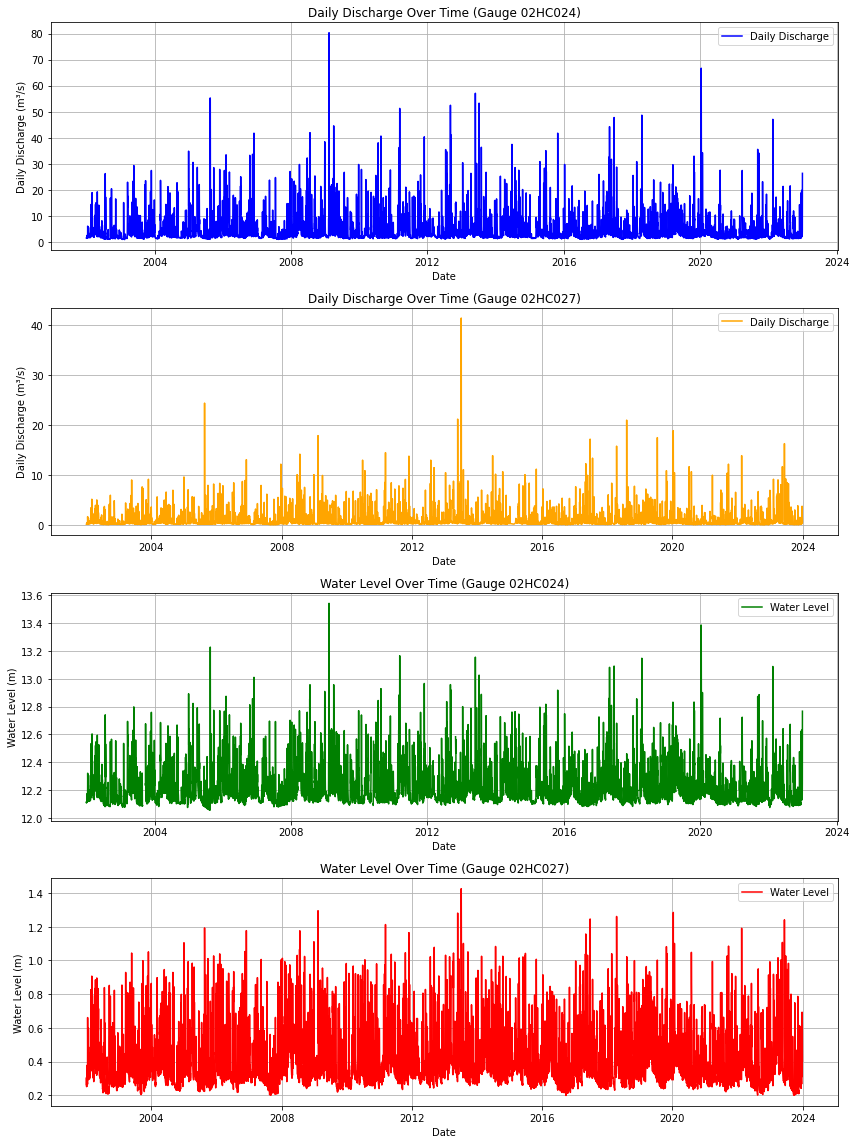

In [12]:
# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

plt.figure(figsize=(12, 16))

# Subplot 1: Daily Discharge for Gauge 02HC024
plt.subplot(4, 1, 1)
plt.plot(gauge_1_data["Date"], gauge_1_data["daily_discharge"], label="Daily Discharge", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Daily Discharge for Gauge 02HC027
plt.subplot(4, 1, 2)
plt.plot(gauge_2_data["Date"], gauge_2_data["daily_discharge"], label="Daily Discharge", color="orange")
plt.xlabel("Date")
plt.ylabel("Daily Discharge (m³/s)")
plt.title("Daily Discharge Over Time (Gauge 02HC027)")
plt.grid(True)
plt.legend()

# Subplot 3: Water Level for Gauge 02HC024
plt.subplot(4, 1, 3)
plt.plot(gauge_1_data["Date"], gauge_1_data["water_level"], label="Water Level", color="green")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 4: Water Level for Gauge 02HC027
plt.subplot(4, 1, 4)
plt.plot(gauge_2_data["Date"], gauge_2_data["water_level"], label="Water Level", color="red")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Water Level Over Time (Gauge 02HC027)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### We notice that water level data can be difficult to interpret, so we will aggregate it by month, analyze the trend line of the top 10% of peaks over time, and evaluate the results.

In [13]:
flow_data_merged["YearMonth"] = flow_data_merged["Date"].dt.to_period("M")
monthly_water_level_gauge_1 = (
    flow_data_merged[flow_data_merged["ID"] == "02HC024"]
    .groupby("YearMonth", as_index=False)["water_level"]
    .mean()
)
monthly_water_level_gauge_2 = (
    flow_data_merged[flow_data_merged["ID"] == "02HC027"]
    .groupby("YearMonth", as_index=False)["water_level"]
    .mean()
)

# Ensure YearMonth is converted to a datetime-like format for plotting purposes
monthly_water_level_gauge_1["YearMonth"] = monthly_water_level_gauge_1["YearMonth"].dt.to_timestamp()
monthly_water_level_gauge_2["YearMonth"] = monthly_water_level_gauge_2["YearMonth"].dt.to_timestamp()


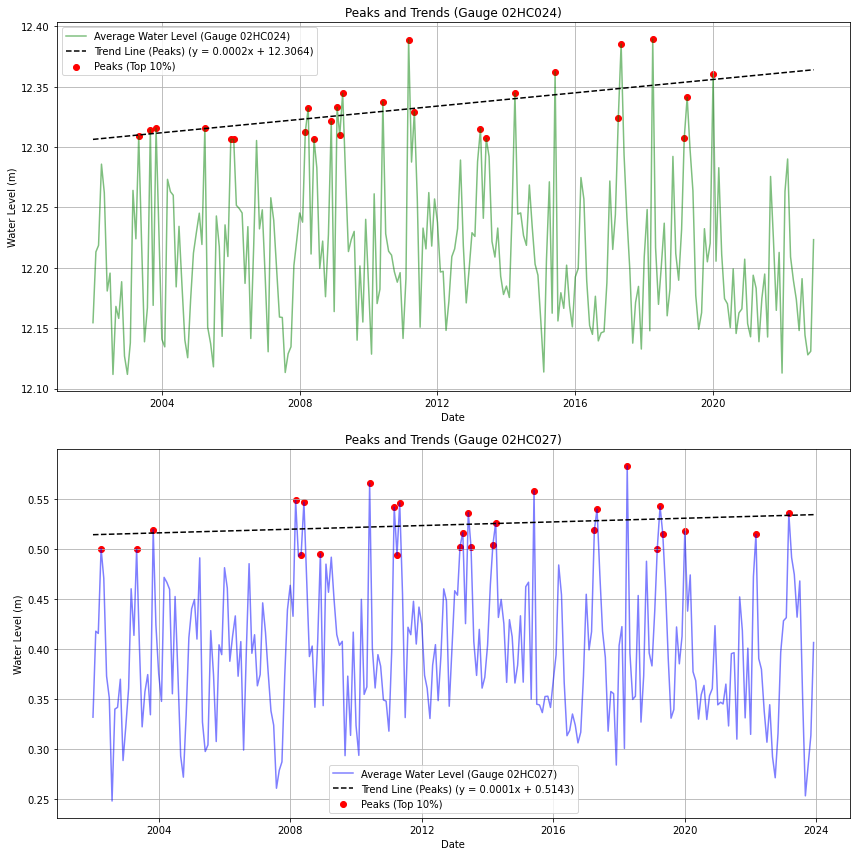

In [14]:
from scipy.stats import linregress

# Identify peaks
peaks_gauge_1 = monthly_water_level_gauge_1[monthly_water_level_gauge_1["water_level"] > monthly_water_level_gauge_1["water_level"].quantile(0.9)]
peaks_gauge_2 = monthly_water_level_gauge_2[monthly_water_level_gauge_2["water_level"] > monthly_water_level_gauge_2["water_level"].quantile(0.9)]

# Calculate trend lines
slope_1, intercept_1, *_ = linregress(peaks_gauge_1.index, peaks_gauge_1["water_level"])
slope_2, intercept_2, *_ = linregress(peaks_gauge_2.index, peaks_gauge_2["water_level"])

# Extract trend line equations
equation_1 = f"y = {slope_1:.4f}x + {intercept_1:.4f}"
equation_2 = f"y = {slope_2:.4f}x + {intercept_2:.4f}"

plt.figure(figsize=(12, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    monthly_water_level_gauge_1["YearMonth"],
    monthly_water_level_gauge_1["water_level"],
    color="green",
    alpha=0.5,
    label="Average Water Level (Gauge 02HC024)",
)
plt.scatter(
    peaks_gauge_1["YearMonth"],
    peaks_gauge_1["water_level"],
    color="red",
    label="Peaks (Top 10%)",
)
plt.plot(
    monthly_water_level_gauge_1["YearMonth"],
    slope_1 * monthly_water_level_gauge_1.index + intercept_1,
    linestyle="--",
    color="black",
    label=f"Trend Line (Peaks) ({equation_1})",
)
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Peaks and Trends (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    monthly_water_level_gauge_2["YearMonth"],
    monthly_water_level_gauge_2["water_level"],
    color="blue",
    alpha=0.5,
    label="Average Water Level (Gauge 02HC027)",
)
plt.scatter(
    peaks_gauge_2["YearMonth"],
    peaks_gauge_2["water_level"],
    color="red",
    label="Peaks (Top 10%)",
)
plt.plot(
    monthly_water_level_gauge_2["YearMonth"],
    slope_2 * monthly_water_level_gauge_2.index + intercept_2,
    linestyle="--",
    color="black",
    label=f"Trend Line (Peaks) ({equation_2})",
)
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Peaks and Trends (Gauge 02HC027)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Extract equations in a text format 
print(equation_1)
print(equation_2)

y = 0.0002x + 12.3064
y = 0.0001x + 0.5143


## Let's try to incorporate snowmelt data and analyze the correlation 

In [16]:
snowmelt_data = pd.read_csv('significant_snow_melt_events_after_freeze.csv')
snowmelt_data.head()

,start_date,end_date,duration,mean_temperature
0,2002-06-04,2002-11-15,165,18.391515
1,2002-11-18,2002-11-26,9,3.566667
2,2002-12-10,2002-12-15,6,2.100000
3,2002-12-18,2002-12-22,5,3.040000
4,2003-03-15,2003-03-29,15,6.420000


In [17]:
# Ensure the date columns in both datasets are in datetime format
snowmelt_data["start_date"] = pd.to_datetime(snowmelt_data["start_date"])
snowmelt_data["end_date"] = pd.to_datetime(snowmelt_data["end_date"])
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])

# Add a column indicating whether a date falls within a snowmelt event
flow_data_merged["snowmelt_event"] = flow_data_merged["Date"].apply(
    lambda x: any((x >= start and x <= end) for start, end in zip(snowmelt_data["start_date"], snowmelt_data["end_date"]))
)


In [18]:
flow_data_merged.head()

,ID,Date,daily_discharge,water_level,YearMonth,snowmelt_event
0,02HC024,2002-01-01,1.560,12.114,2002-01,False
1,02HC027,2002-01-01,0.193,0.263,2002-01,False
2,02HC024,2002-01-02,1.490,12.108,2002-01,False
3,02HC027,2002-01-02,0.186,0.305,2002-01,False
4,02HC027,2002-01-03,0.185,0.252,2002-01,False


In [19]:
# Filter data for snowmelt and non-snowmelt periods
snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == True]
non_snowmelt_period_data = flow_data_merged[flow_data_merged["snowmelt_event"] == False]

# Compute summary statistics
print("Snowmelt Period Statistics:")
print(snowmelt_period_data[["daily_discharge", "water_level"]].describe())

print("\nNon-Snowmelt Period Statistics:")
print(non_snowmelt_period_data[["daily_discharge", "water_level"]].describe())


Snowmelt Period Statistics:
       daily_discharge   water_level
count     11684.000000  11616.000000
mean          2.709326      6.134863
std           4.244715      5.908261
min           0.064000      0.199000
25%           0.406000      0.339000
50%           1.550000      0.853500
75%           3.040000     12.171000
max          80.300000     13.541000

Non-Snowmelt Period Statistics:
       daily_discharge  water_level
count      4021.000000  4007.000000
mean          2.147509     6.184917
std           3.471583     5.905409
min           0.086000     0.209000
25%           0.370000     0.346000
50%           1.480000     0.873000
75%           2.520000    12.157000
max          66.700000    13.385000


### Let's look at the yearly average discharge/Water Level and analyze the data

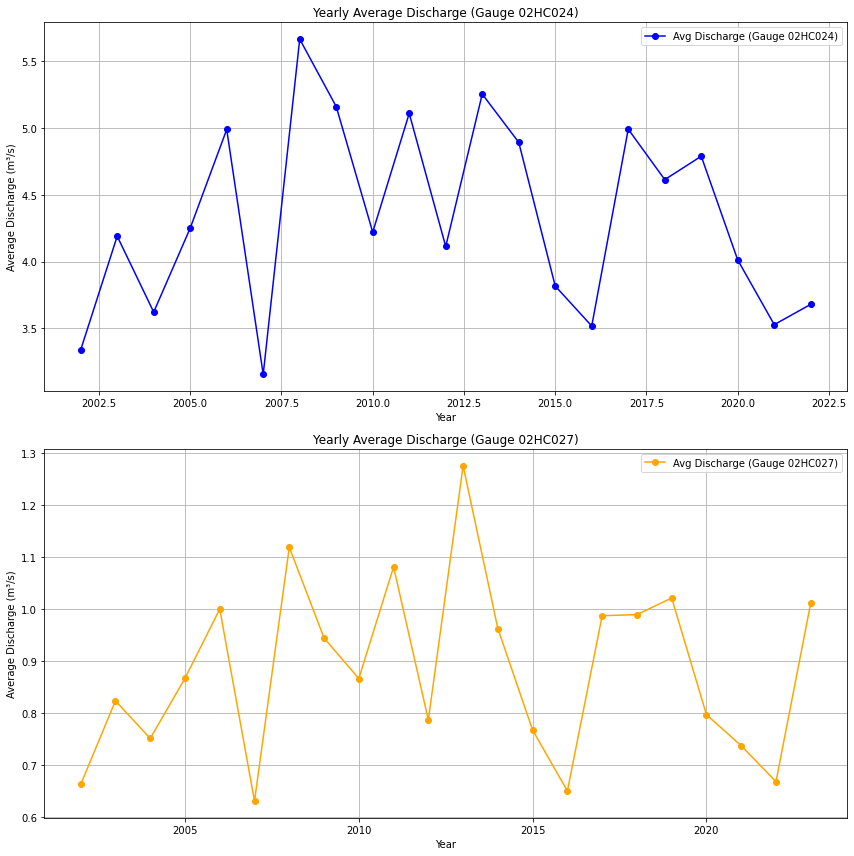

In [20]:
# Aggregate data by year for each gauge
gauge_1_yearly_discharge = (
    flow_data_merged[flow_data_merged["ID"] == "02HC024"]
    .groupby(flow_data_merged["Date"].dt.year)["daily_discharge"]
    .mean()
    .reset_index()
)
gauge_1_yearly_discharge.columns = ["Year", "Avg Discharge"]

gauge_2_yearly_discharge = (
    flow_data_merged[flow_data_merged["ID"] == "02HC027"]
    .groupby(flow_data_merged["Date"].dt.year)["daily_discharge"]
    .mean()
    .reset_index()
)
gauge_2_yearly_discharge.columns = ["Year", "Avg Discharge"]

# Create the plot
plt.figure(figsize=(12, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    gauge_1_yearly_discharge["Year"],
    gauge_1_yearly_discharge["Avg Discharge"],
    color="blue",
    marker="o",
    label="Avg Discharge (Gauge 02HC024)",
)
plt.xlabel("Year")
plt.ylabel("Average Discharge (m³/s)")
plt.title("Yearly Average Discharge (Gauge 02HC024)")
plt.grid(True)
plt.legend()

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    gauge_2_yearly_discharge["Year"],
    gauge_2_yearly_discharge["Avg Discharge"],
    color="orange",
    marker="o",
    label="Avg Discharge (Gauge 02HC027)",
)
plt.xlabel("Year")
plt.ylabel("Average Discharge (m³/s)")
plt.title("Yearly Average Discharge (Gauge 02HC027)")
plt.grid(True)
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


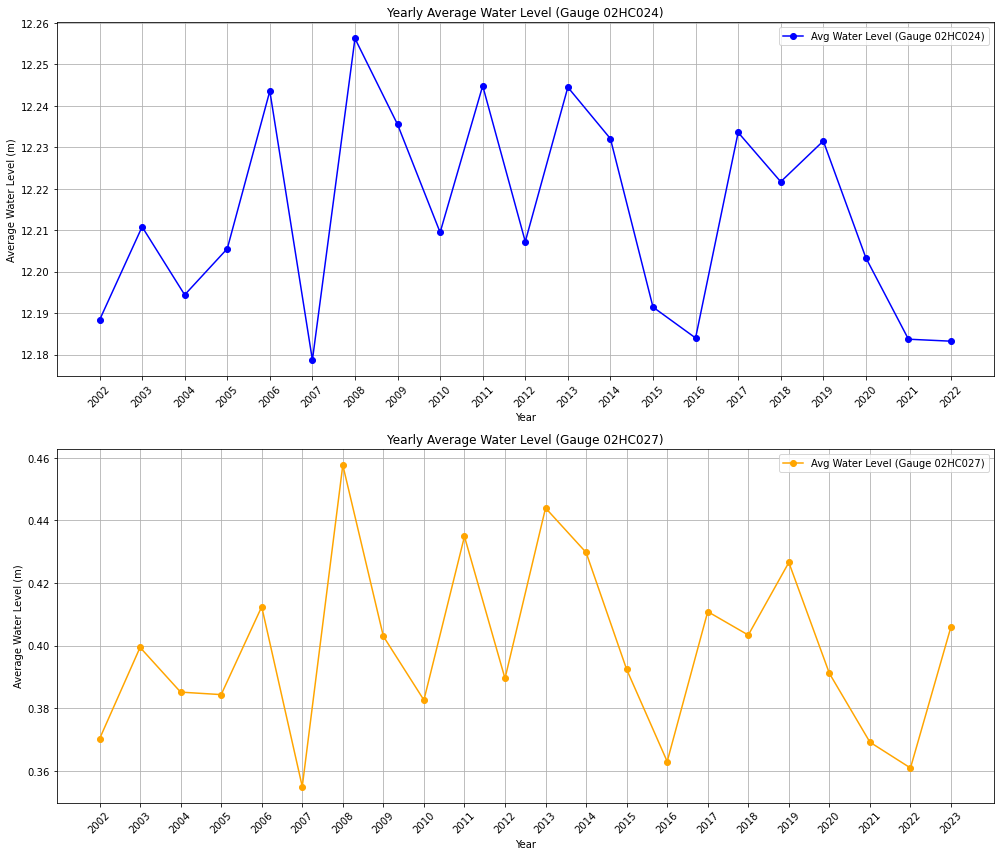

In [21]:
# Aggregate data by year for each gauge
gauge_1_yearly_avg_water_level = (
    flow_data_merged[flow_data_merged["ID"] == "02HC024"]
    .groupby(flow_data_merged["Date"].dt.year)["water_level"]
    .mean()
)

gauge_2_yearly_avg_water_level = (
    flow_data_merged[flow_data_merged["ID"] == "02HC027"]
    .groupby(flow_data_merged["Date"].dt.year)["water_level"]
    .mean()
)

# Create the plot
plt.figure(figsize=(14, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(
    gauge_1_yearly_avg_water_level.index,
    gauge_1_yearly_avg_water_level.values,
    marker="o",
    label="Avg Water Level (Gauge 02HC024)",
    color="blue",
)
plt.xticks(
    np.arange(
        gauge_1_yearly_avg_water_level.index.min(),
        gauge_1_yearly_avg_water_level.index.max() + 1,
        step=1,
    ),
    rotation=45,
)
plt.xlabel("Year")
plt.ylabel("Average Water Level (m)")
plt.title("Yearly Average Water Level (Gauge 02HC024)")
plt.legend()
plt.grid(True)

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(
    gauge_2_yearly_avg_water_level.index,
    gauge_2_yearly_avg_water_level.values,
    marker="o",
    label="Avg Water Level (Gauge 02HC027)",
    color="orange",
)
plt.xticks(
    np.arange(
        gauge_2_yearly_avg_water_level.index.min(),
        gauge_2_yearly_avg_water_level.index.max() + 1,
        step=1,
    ),
    rotation=45,
)
plt.xlabel("Year")
plt.ylabel("Average Water Level (m)")
plt.title("Yearly Average Water Level (Gauge 02HC027)")
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


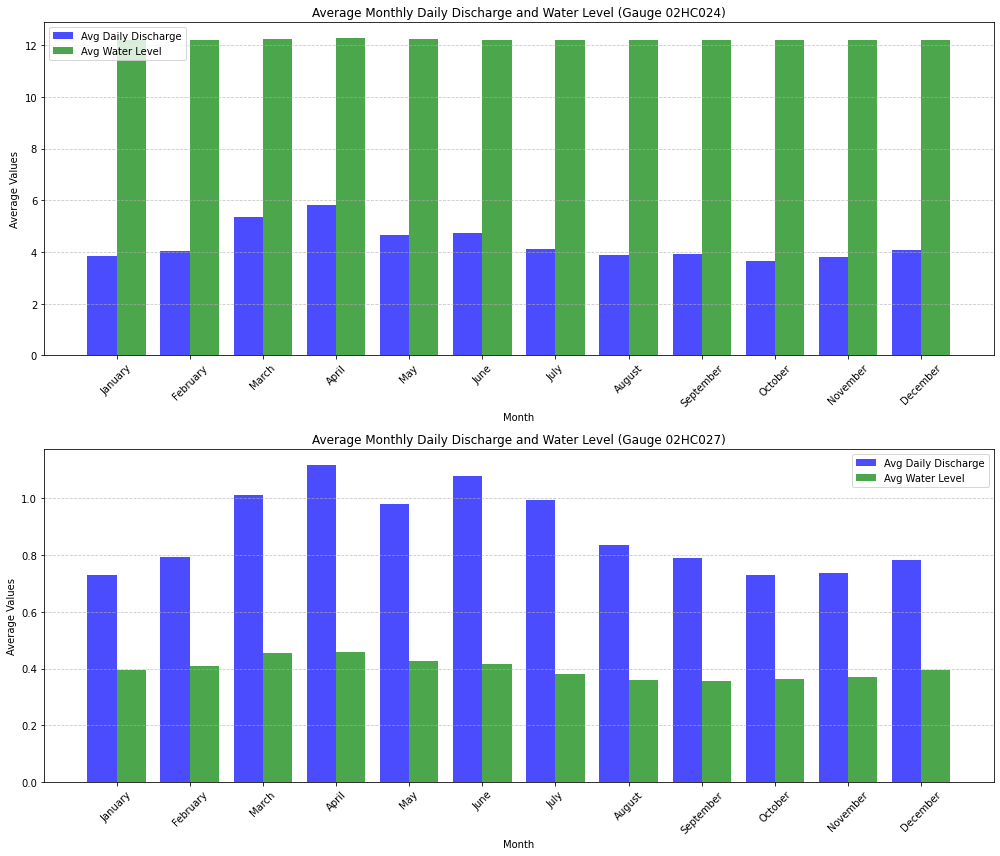

In [22]:
# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Group data by Month and calculate averages for each gauge
gauge_1_monthly_avg = (
    gauge_1_data.groupby(gauge_1_data["Date"].dt.month)[
        ["daily_discharge", "water_level"]
    ].mean()
)
gauge_2_monthly_avg = (
    gauge_2_data.groupby(gauge_2_data["Date"].dt.month)[
        ["daily_discharge", "water_level"]
    ].mean()
)

# Rename the index to month names
gauge_1_monthly_avg.index = [calendar.month_name[i] for i in gauge_1_monthly_avg.index]
gauge_2_monthly_avg.index = [calendar.month_name[i] for i in gauge_2_monthly_avg.index]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot for Gauge 02HC024
x = range(len(gauge_1_monthly_avg))
width = 0.4
axes[0].bar(
    x,
    gauge_1_monthly_avg["daily_discharge"],
    width=width,
    label="Avg Daily Discharge",
    color="blue",
    alpha=0.7,
)
axes[0].bar(
    [i + width for i in x],
    gauge_1_monthly_avg["water_level"],
    width=width,
    label="Avg Water Level",
    color="green",
    alpha=0.7,
)
axes[0].set_xticks([i + width / 2 for i in x])
axes[0].set_xticklabels(gauge_1_monthly_avg.index, rotation=45)
axes[0].set_title("Average Monthly Daily Discharge and Water Level (Gauge 02HC024)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Values")
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot for Gauge 02HC027
x = range(len(gauge_2_monthly_avg))
axes[1].bar(
    x,
    gauge_2_monthly_avg["daily_discharge"],
    width=width,
    label="Avg Daily Discharge",
    color="blue",
    alpha=0.7,
)
axes[1].bar(
    [i + width for i in x],
    gauge_2_monthly_avg["water_level"],
    width=width,
    label="Avg Water Level",
    color="green",
    alpha=0.7,
)
axes[1].set_xticks([i + width / 2 for i in x])
axes[1].set_xticklabels(gauge_2_monthly_avg.index, rotation=45)
axes[1].set_title("Average Monthly Daily Discharge and Water Level (Gauge 02HC027)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average Values")
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### We can notice that daily discharge starts to increase during snowmelt period. However for better visualization let's focus on last 10 years

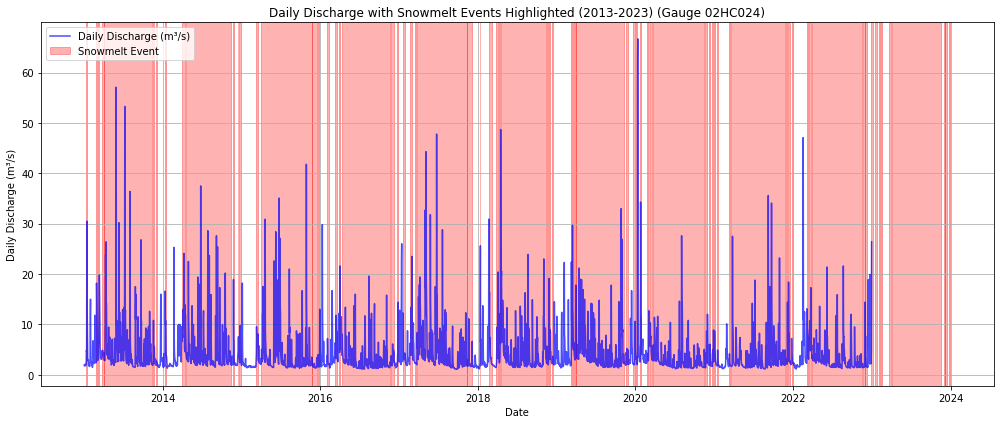

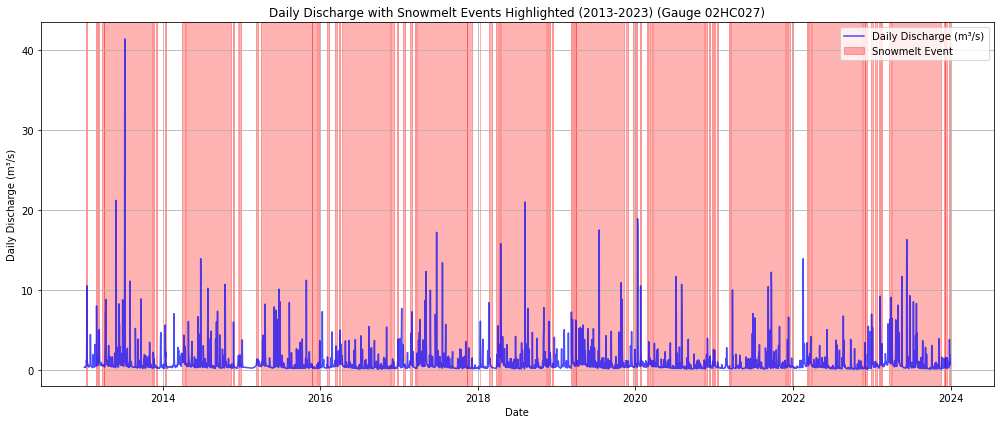

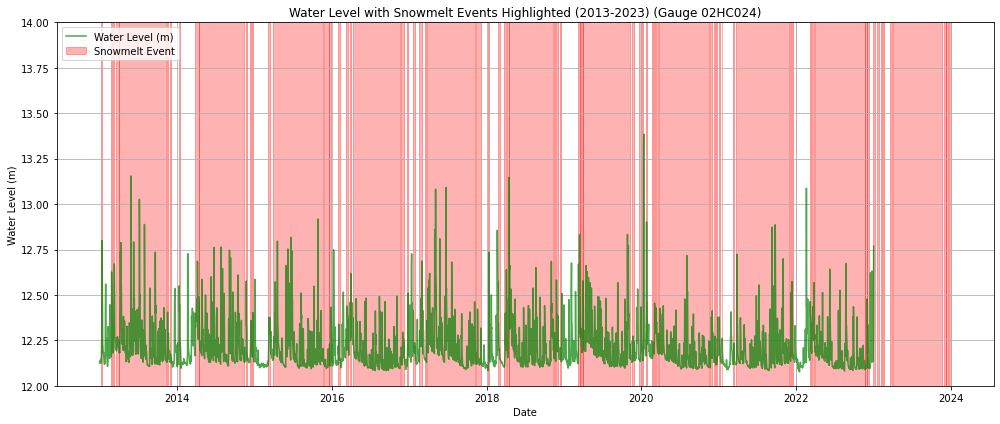

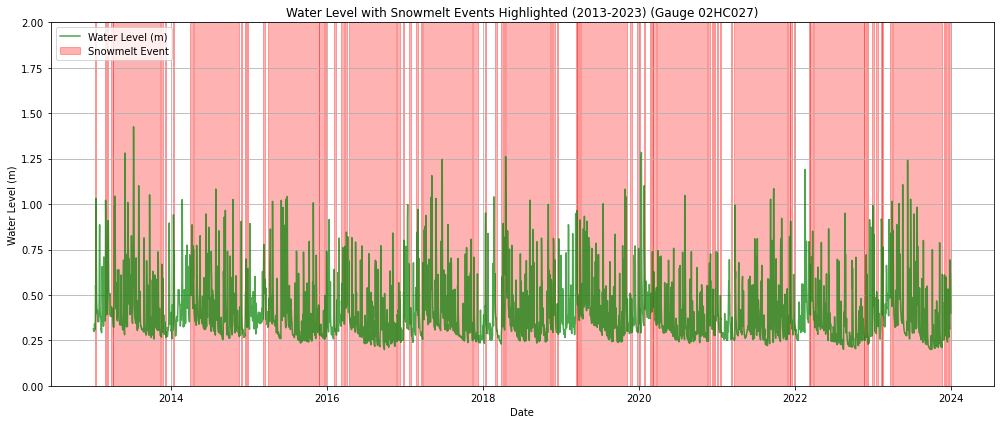

In [23]:
# Define the desired date range 
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-12-31")

# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Helper function to plot
def plot_with_snowmelt(data, parameter, ylabel, title, color, ylim=None, gauge=None):
    plt.figure(figsize=(14, 6))
    plt.plot(
        data[(data["Date"] >= start_date) & (data["Date"] <= end_date)]["Date"],
        data[(data["Date"] >= start_date) & (data["Date"] <= end_date)][parameter],
        label=ylabel,
        color=color,
        alpha=0.7,
    )

    # Highlight snowmelt periods
    added_legend = False
    for _, row in snowmelt_data[(snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)].iterrows():
        plt.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
            label="Snowmelt Event" if not added_legend else None,  # Add legend only once
        )
        added_legend = True

    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(f"{title} (Gauge {gauge})" if gauge else title)
    if ylim:
        plt.ylim(*ylim)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot Daily Discharge for each gauge
plot_with_snowmelt(
    gauge_1_data, 
    "daily_discharge", 
    "Daily Discharge (m³/s)", 
    "Daily Discharge with Snowmelt Events Highlighted (2013-2023)", 
    "blue", 
    gauge="02HC024"
)

plot_with_snowmelt(
    gauge_2_data, 
    "daily_discharge", 
    "Daily Discharge (m³/s)", 
    "Daily Discharge with Snowmelt Events Highlighted (2013-2023)", 
    "blue", 
    gauge="02HC027"
)

# Plot Water Level for each gauge
plot_with_snowmelt(
    gauge_1_data, 
    "water_level", 
    "Water Level (m)", 
    "Water Level with Snowmelt Events Highlighted (2013-2023)", 
    "green", 
    ylim=(12, 14), 
    gauge="02HC024"
)

plot_with_snowmelt(
    gauge_2_data, 
    "water_level", 
    "Water Level (m)", 
    "Water Level with Snowmelt Events Highlighted (2013-2023)", 
    "green", 
    ylim=(0, 2), 
    gauge="02HC027"
)


### We will merge these two graphs for better comparison below

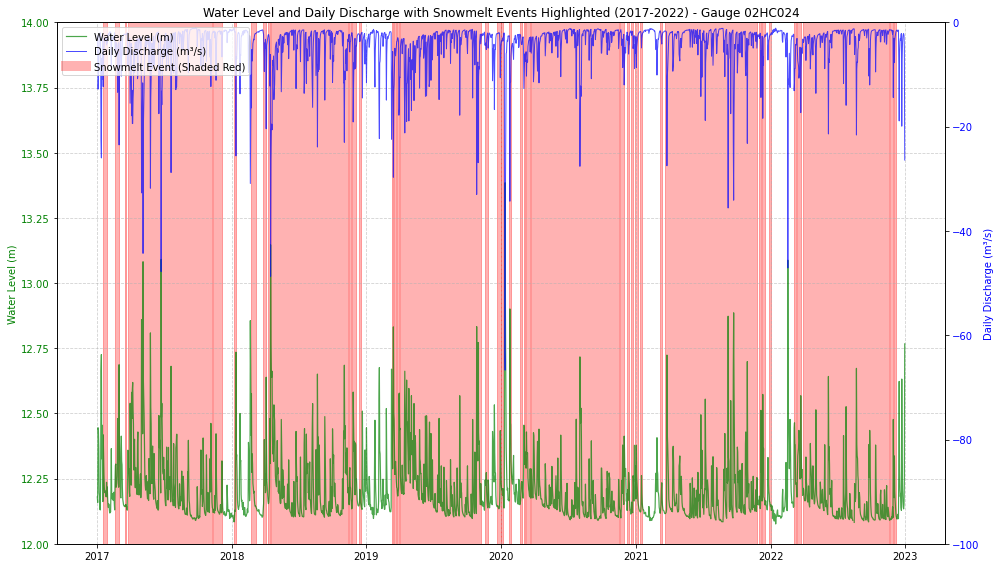

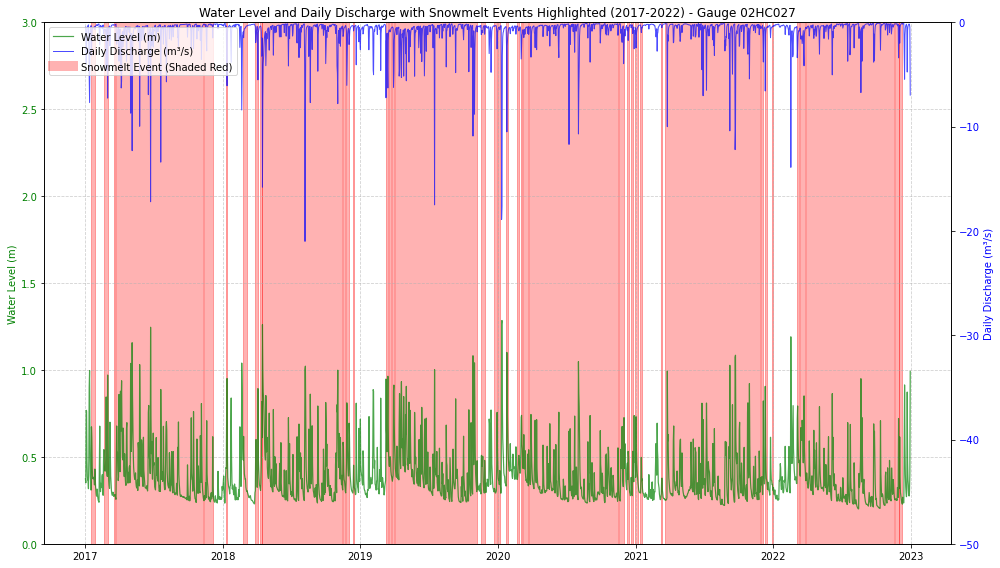

In [24]:
# Define the date range 
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2022-12-31")

# Filter data for each gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Helper function to plot 
def plot_gauge_data_with_snowmelt(data, gauge_id, water_level_ylim=(12, 14), discharge_ylim=(-70, 0)):
    # Filter data for the given date range
    filtered_data = data[
        (data["Date"] >= start_date) & (data["Date"] <= end_date)
    ]

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot Water Level (Above the X-Axis)
    water_level_line = ax1.plot(
        filtered_data["Date"],
        filtered_data["water_level"],
        label="Water Level (m)",
        color="green",
        alpha=0.7,
        linewidth=1.2,
    )

    # Set Water Level axis properties
    ax1.set_ylabel("Water Level (m)", color="green")
    ax1.set_ylim(water_level_ylim)  # Set Water Level range dynamically
    ax1.tick_params(axis="y", labelcolor="green")

    # Add a secondary axis for Daily Discharge (Below the X-Axis)
    ax2 = ax1.twinx()
    daily_discharge_line = ax2.plot(
        filtered_data["Date"],
        -filtered_data["daily_discharge"],  # Flip discharge values to go below X-axis
        label="Daily Discharge (m³/s)",
        color="blue",
        alpha=0.7,
        linewidth=1,
    )

    # Set Daily Discharge axis properties
    ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(discharge_ylim)  

    # Highlight Snowmelt Events
    for _, row in snowmelt_data[
        (snowmelt_data["start_date"] >= start_date) & (snowmelt_data["end_date"] <= end_date)
    ].iterrows():
        ax1.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
        )

    # Add a legend entry for Snowmelt Event
    snowmelt_patch = plt.Line2D(
        [0], [0],
        color="red",
        alpha=0.3,
        linewidth=10,
        label="Snowmelt Event (Shaded Red)"
    )

    # Format X-axis
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    # Add grid, title, and legend
    plt.title(f"Water Level and Daily Discharge with Snowmelt Events Highlighted (2017-2022) - Gauge {gauge_id}")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Combine Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2 + [snowmelt_patch], labels1 + labels2 + ["Snowmelt Event (Shaded Red)"], loc="upper left")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Plot for Gauge 02HC024 
plot_gauge_data_with_snowmelt(gauge_1_data, "02HC024", water_level_ylim=(12, 14), discharge_ylim=(-100, 0))

# Plot for Gauge 02HC027 
plot_gauge_data_with_snowmelt(gauge_2_data, "02HC027", water_level_ylim=(0, 3), discharge_ylim=(-50, 0))



## Now let's analyze how significant rain events impact water level and daily discharge 

In [25]:
significant_rain_events = pd.read_csv('significant_rain_events_filtered.csv')

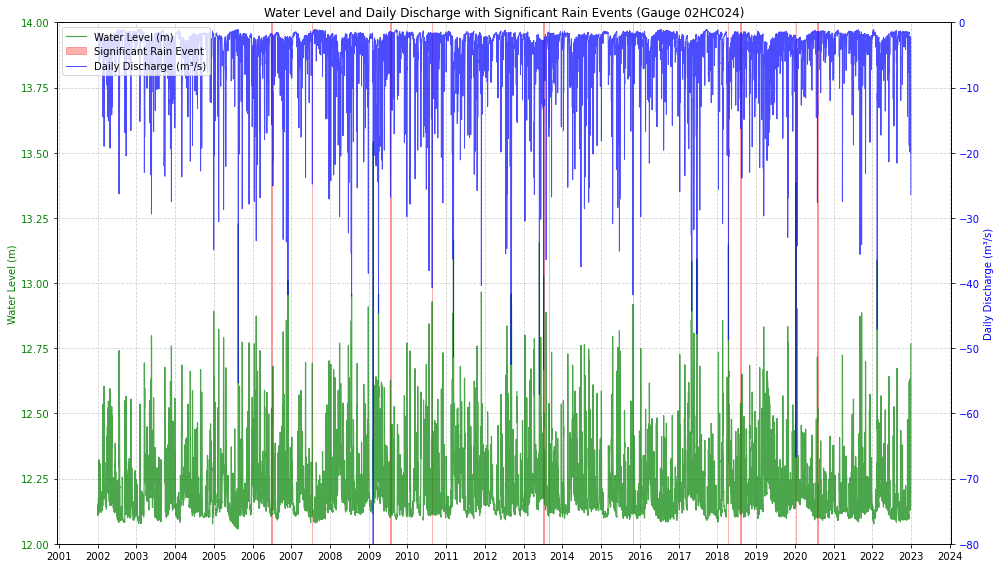

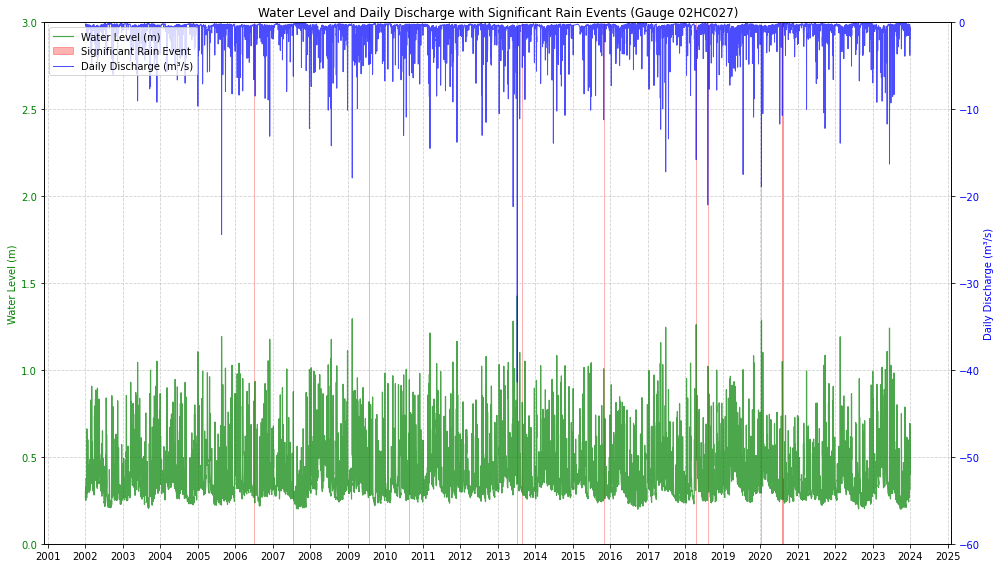

In [26]:
# Helper function for plotting 
def plot_gauge_with_rain_events(data, rain_events, gauge_id, start_date, end_date, water_level_ylim=(12, 14), discharge_ylim=(-70, 0)):
    # Filter data for the given date range
    filtered_data = data[(data["Date"] >= start_date) & (data["Date"] <= end_date)]

    # Filter significant rain events for the date range
    rain_events["start_date"] = pd.to_datetime(rain_events["start_date"])
    rain_events["end_date"] = pd.to_datetime(rain_events["end_date"])
    filtered_rain_events = rain_events[
        (rain_events["start_date"] >= start_date) & 
        (rain_events["end_date"] <= end_date)
    ]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot Water Level (Above the X-Axis)
    ax1.plot(
        filtered_data["Date"],
        filtered_data["water_level"],
        label="Water Level (m)",
        color="green",
        alpha=0.7,
        linewidth=1.2,
    )
    ax1.set_ylabel("Water Level (m)", color="green")
    ax1.set_ylim(water_level_ylim)  
    ax1.tick_params(axis="y", labelcolor="green")

    # Add a secondary axis for Daily Discharge (Below the X-Axis)
    ax2 = ax1.twinx()
    ax2.plot(
        filtered_data["Date"],
        -filtered_data["daily_discharge"],  # Flip discharge values to go below X-axis
        label="Daily Discharge (m³/s)",
        color="blue",
        alpha=0.7,
        linewidth=1,
    )
    ax2.set_ylabel("Daily Discharge (m³/s)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(discharge_ylim)  

    # Highlight Significant Rain Events
    for _, row in filtered_rain_events.iterrows():
        ax1.axvspan(
            row["start_date"],
            row["end_date"],
            color="red",
            alpha=0.3,
            label="Significant Rain Event" if _ == 0 else None,
        )

    # Format X-axis
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    # Add grid, title, and legend
    plt.title(f"Water Level and Daily Discharge with Significant Rain Events (Gauge {gauge_id})")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Combine Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


# Define the date range
start_date = pd.Timestamp("2002-01-01")
end_date = pd.Timestamp("2023-12-31")

# Filter data by gauge
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Plot for Gauge 02HC024
plot_gauge_with_rain_events(
    data=gauge_1_data,
    rain_events=significant_rain_events,
    gauge_id="02HC024",
    start_date=start_date,
    end_date=end_date,
    water_level_ylim=(12, 14),  
    discharge_ylim=(-80, 0)
)

# Plot for Gauge 02HC027
plot_gauge_with_rain_events(
    data=gauge_2_data,
    rain_events=significant_rain_events,
    gauge_id="02HC027",
    start_date=start_date,
    end_date=end_date,
    water_level_ylim=(0, 3),  
    discharge_ylim=(-60, 0)
)


### The duration of the rain events are short. Thus, let's narrow done tha date range so we can look at each event closer and analyze it. Also, one day events are represented by a thin line, thus we will adjust the date to better visualize the graphs.

In [27]:
def plot_significant_rain_events(data, rain_events, gauge_id, water_level_ylim=(11, 14), discharge_ylim=(-70, 0)):
    # Extend start and end dates by ±10 days
    rain_events["extended_start_date"] = rain_events["start_date"] - pd.Timedelta(days=10)
    rain_events["extended_end_date"] = rain_events["end_date"] + pd.Timedelta(days=10)

    for index, row in rain_events.iterrows():
        extended_start = row["extended_start_date"]
        extended_end = row["extended_end_date"]
        event_start = row["start_date"]
        event_end = row["end_date"]

        # Extend only the end date by 1 day for short events
        adjusted_end = event_end + pd.Timedelta(days=1) if (event_end - event_start).days < 2 else event_end

        # Filter flow data for the extended date range
        event_data = data[
            (data["Date"] >= extended_start) & (data["Date"] <= extended_end)
        ]

        # Create a new plot
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # Plot Water Level
        ax1.plot(
            event_data["Date"],
            event_data["water_level"],
            label="Water Level (m)",
            color="green",
            alpha=0.7,
            linewidth=1.2,
        )
        ax1.set_ylabel("Water Level (m)", color="green")
        ax1.tick_params(axis="y", labelcolor="green")
        ax1.set_ylim(water_level_ylim)

        # Add a secondary axis for Daily Discharge
        ax2 = ax1.twinx()
        ax2.plot(
            event_data["Date"],
            -event_data["daily_discharge"],  
            label="Daily Discharge (Below Axis, m³/s)",
            color="blue",
            alpha=0.7,
            linewidth=1,
        )
        ax2.set_ylabel("Daily Discharge (m³/s, Below Axis)", color="blue")
        ax2.tick_params(axis="y", labelcolor="blue")
        ax2.set_ylim(discharge_ylim)

        # Highlight the original rain event period with adjusted bounds
        ax1.axvspan(event_start, adjusted_end, color="red", alpha=0.3, label="Rain Event Period")

        # Add title
        plt.title("Water Level and Daily Discharge During Significant Rain Events", fontsize = 16)

        # Add Info Box Outside the Plot
        info_text = (
            f"Gauge: {gauge_id}\n"
            f"Start Date: {row['start_date'].date()}\n"
            f"End Date: {row['end_date'].date()}\n"
            f"Total Precipitation: {row['total_precipitation']} mm\n"
            f"Avg Intensity: {row['average_intensity']} mm/day"
        )
        # Adjust position to place it outside the plot area
        plt.gcf().text(0.95, 0.5, info_text, fontsize=10, ha="left", va="center", bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.9))

        # Combine Legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

        # Adjust layout and show plot
        plt.tight_layout()
        plt.subplots_adjust(right=0.9)  # Create space for the info box
        plt.show()


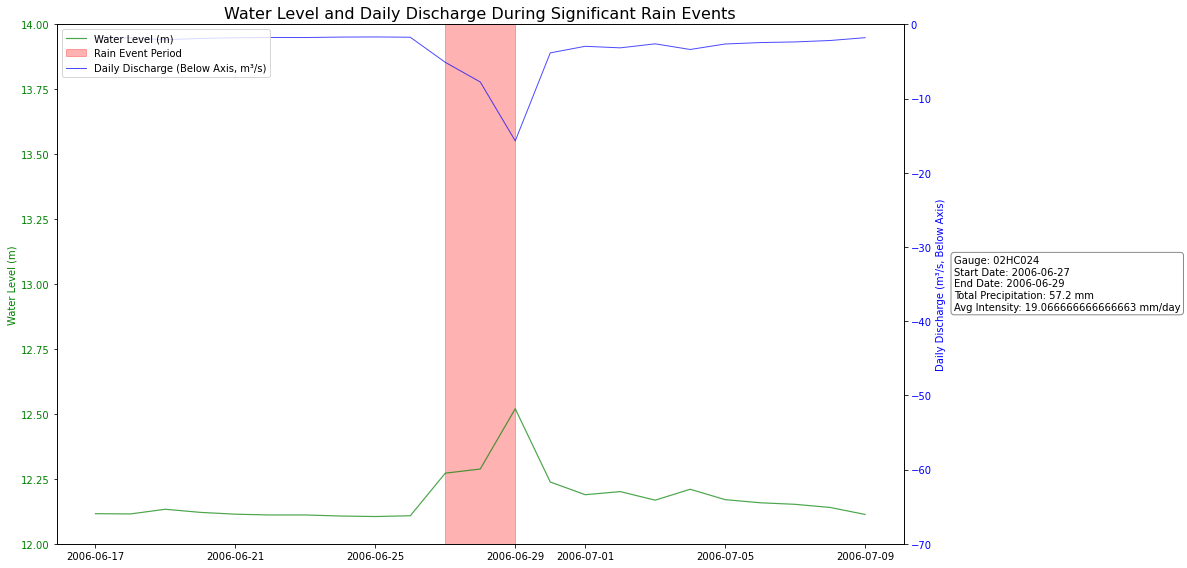

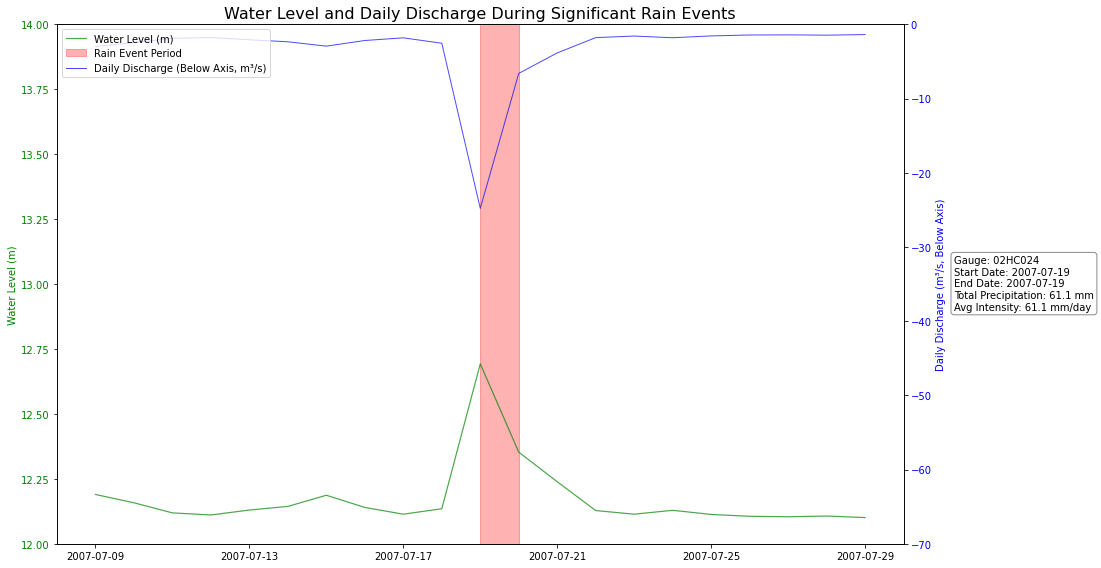

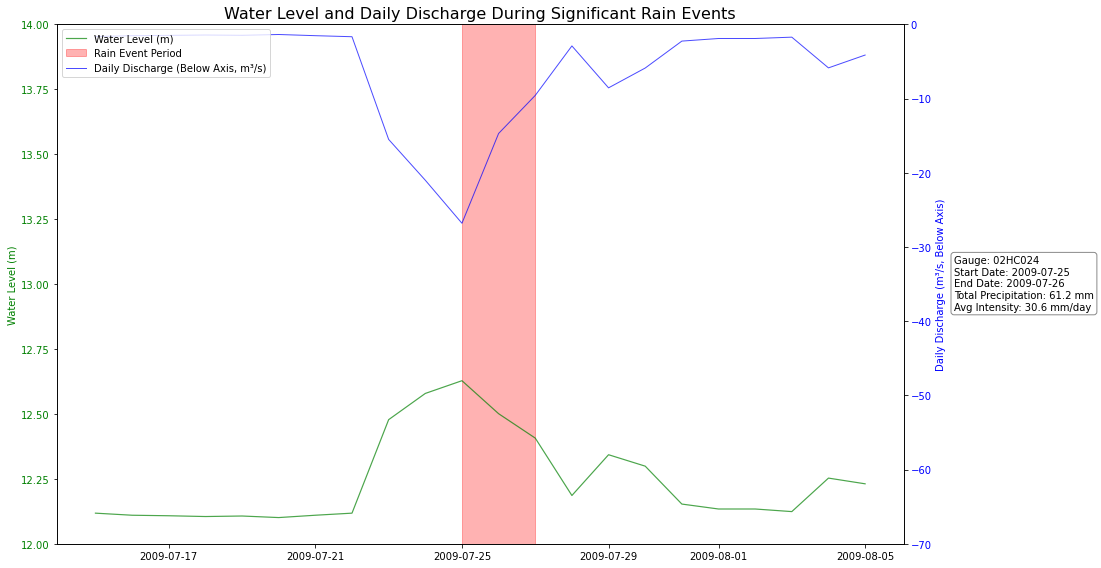

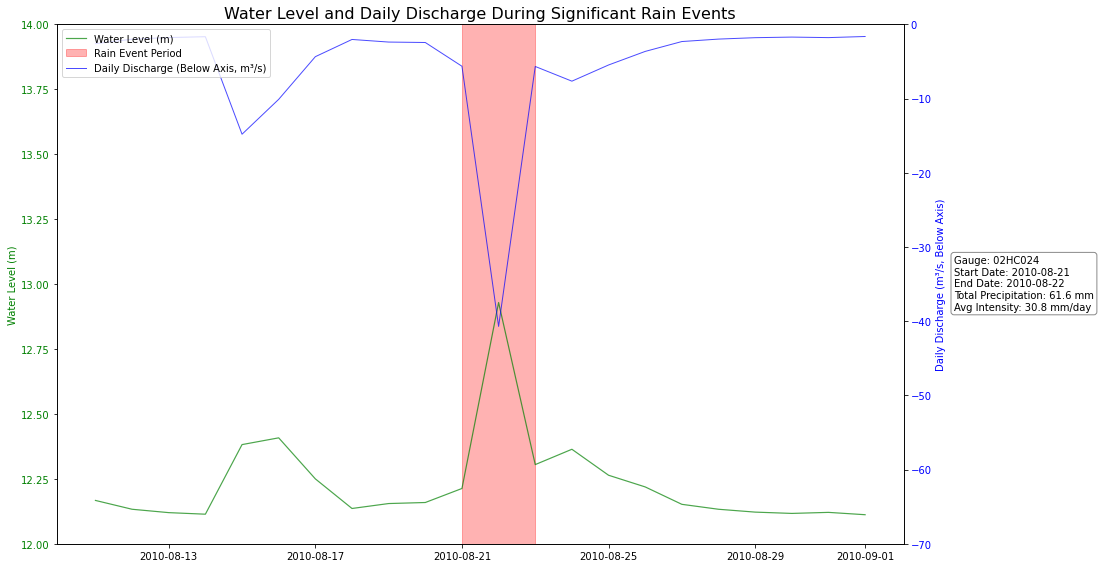

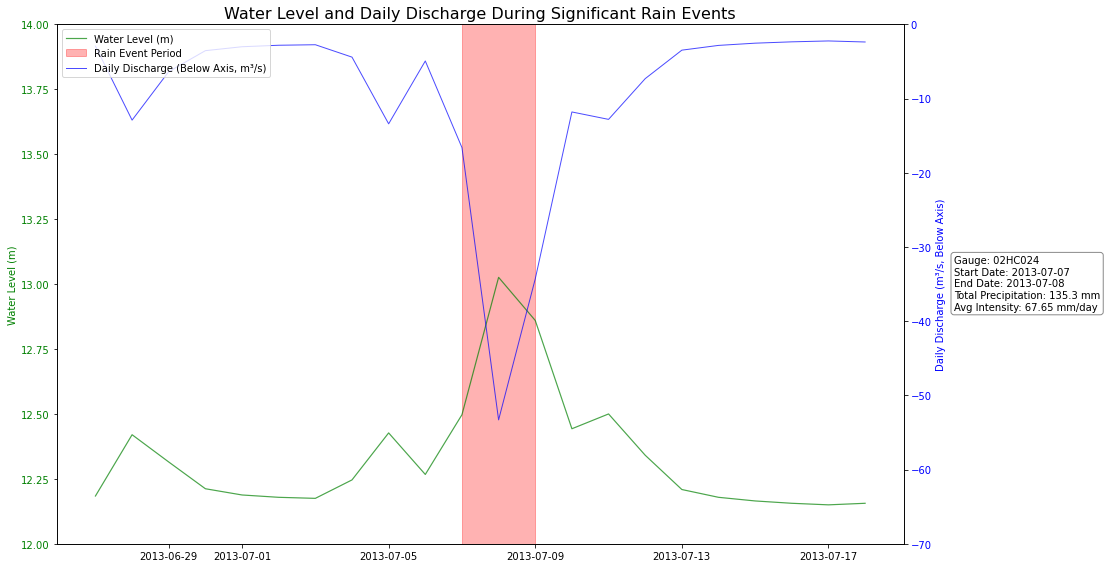

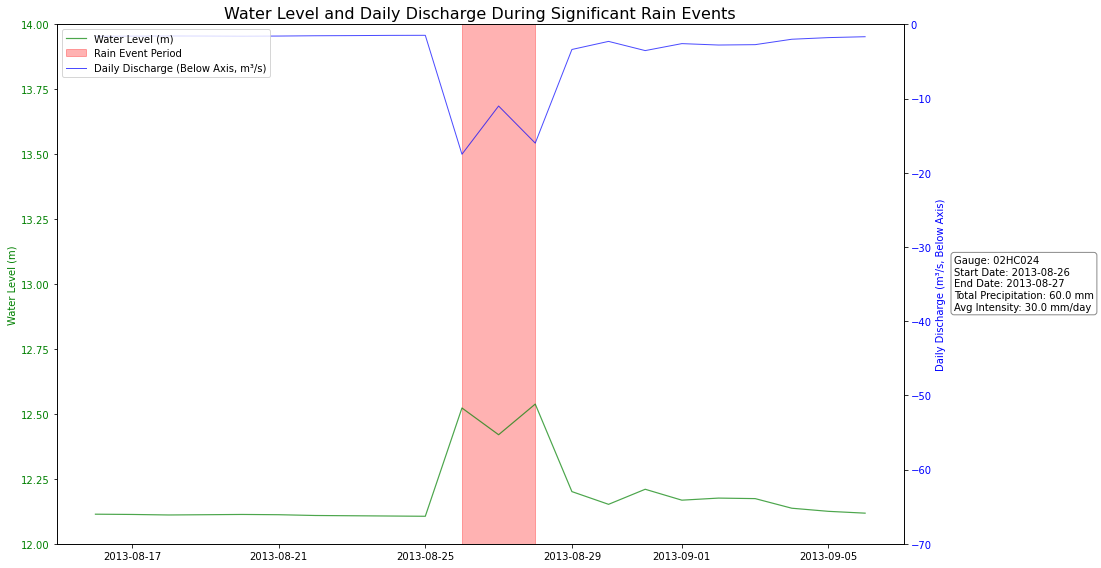

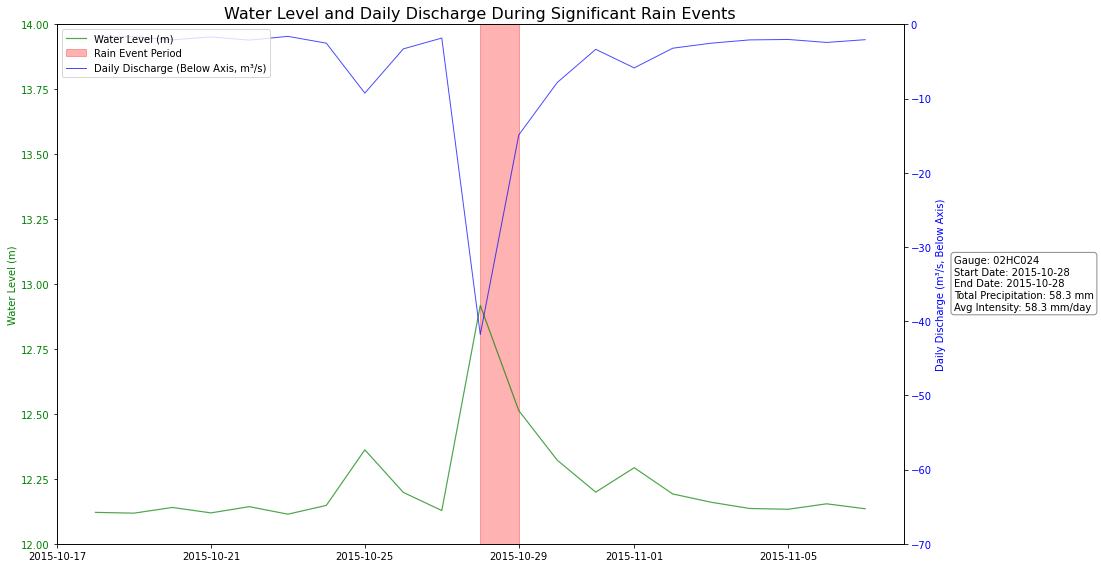

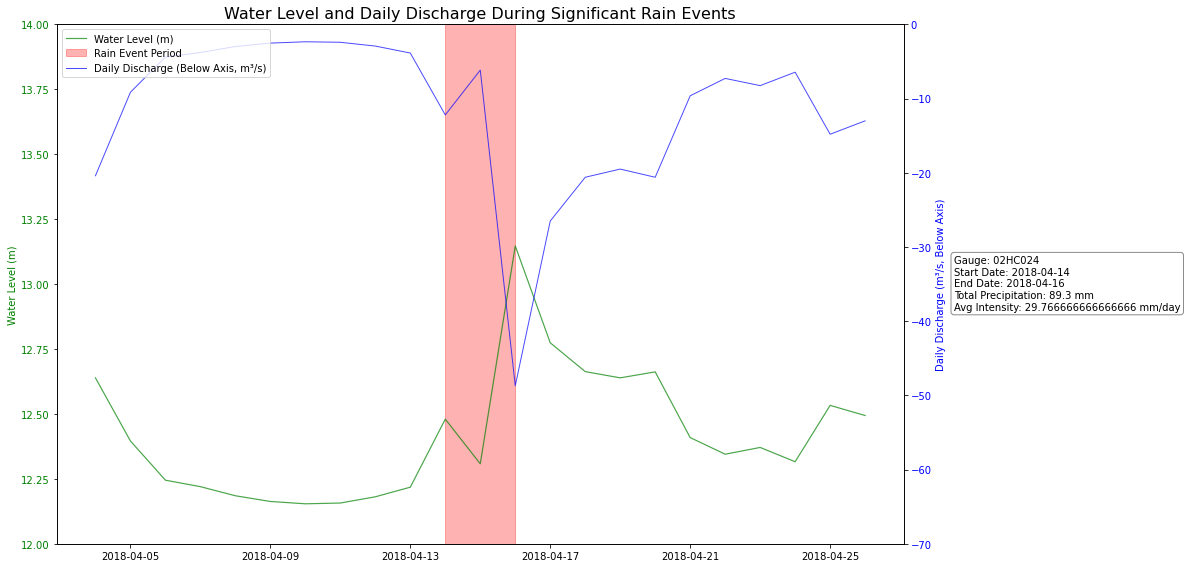

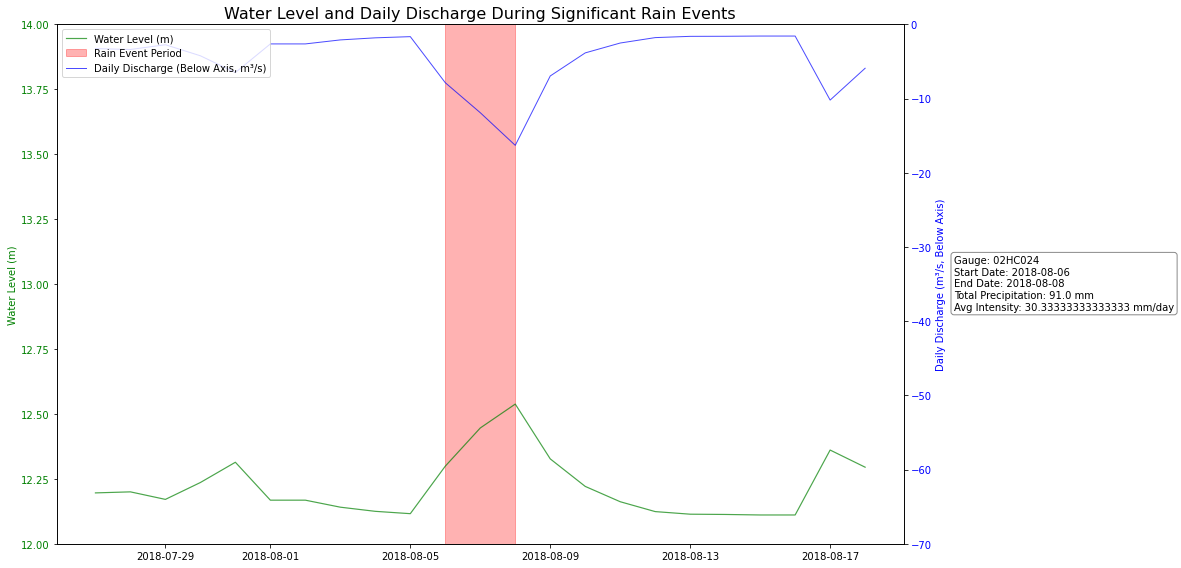

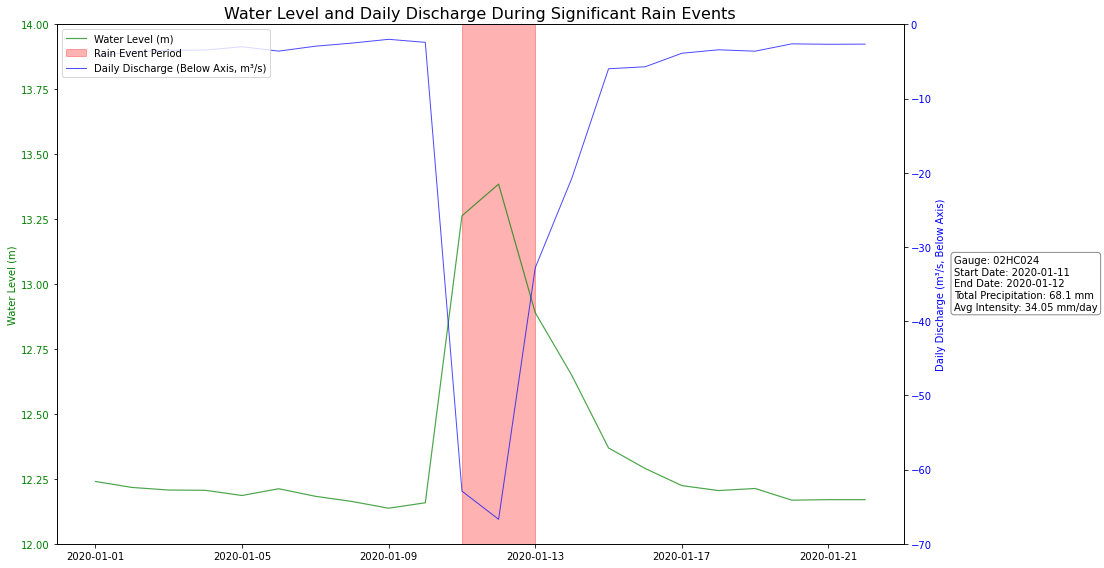

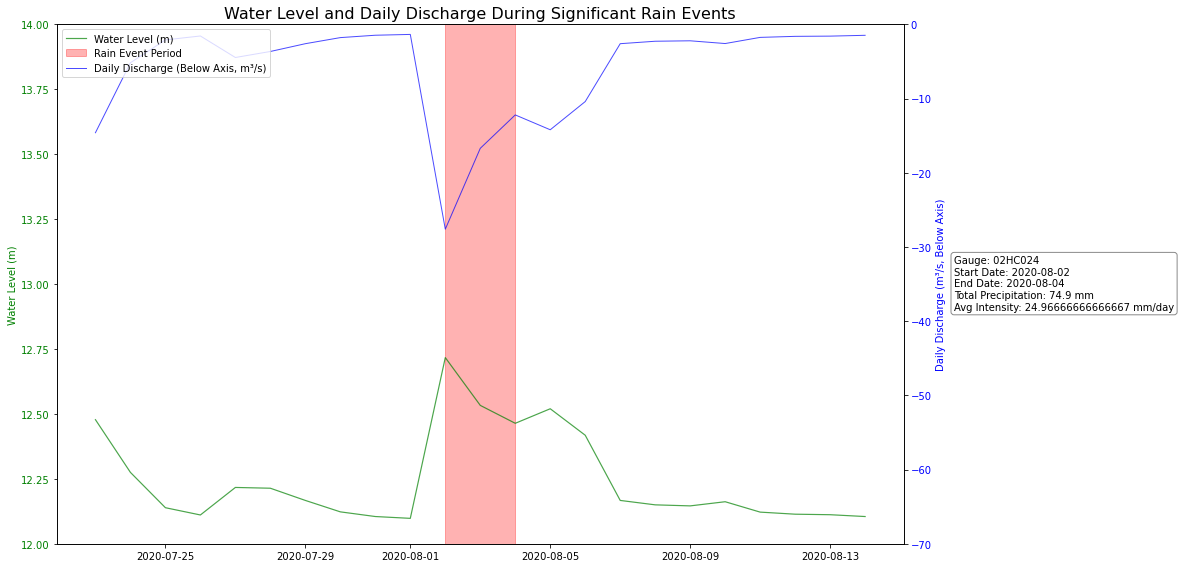

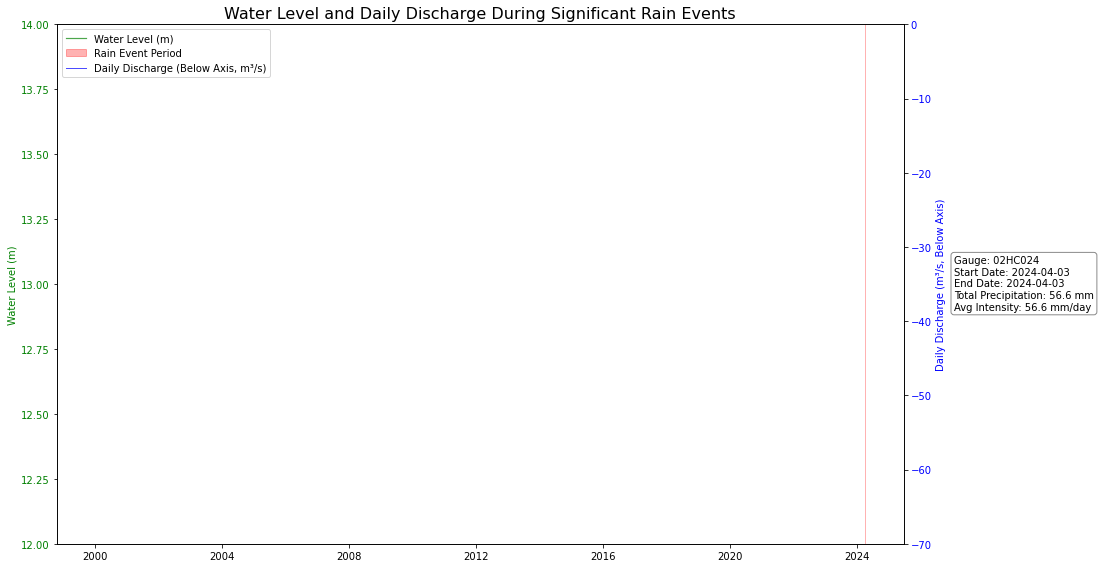

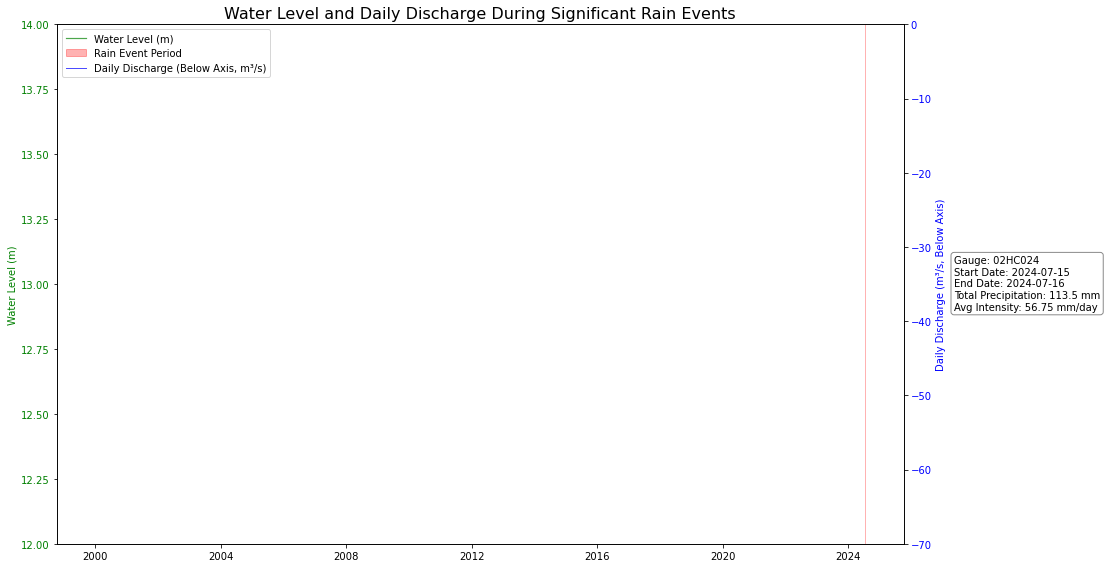

In [28]:
# Plot for Gauge 02HC024
plot_significant_rain_events(
    data=gauge_1_data,
    rain_events=significant_rain_events,
    gauge_id="02HC024",
    water_level_ylim=(12, 14),
    discharge_ylim=(-70, 0)
)

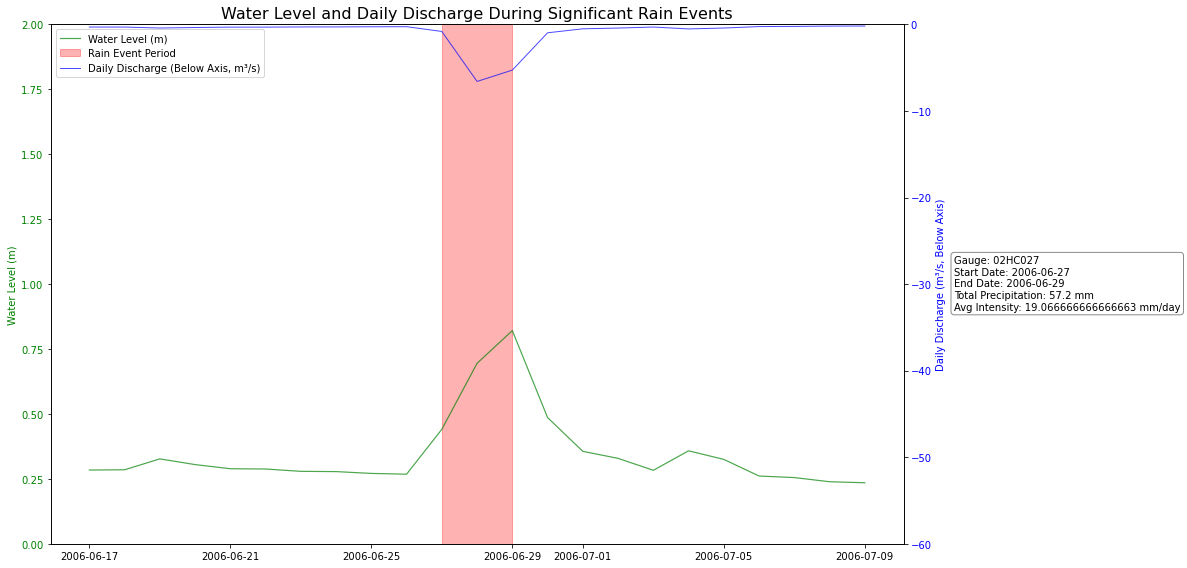

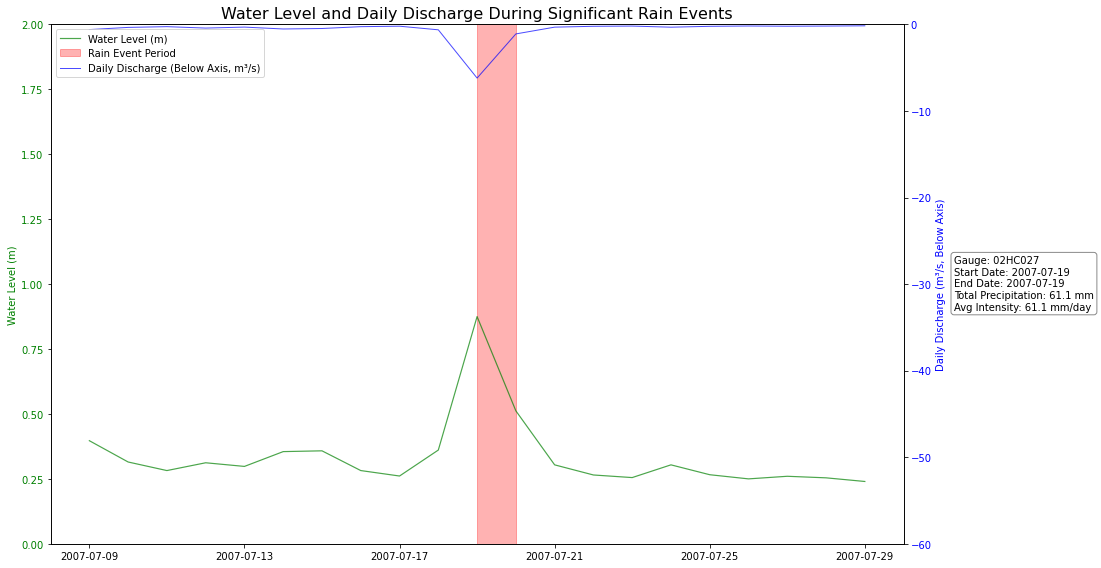

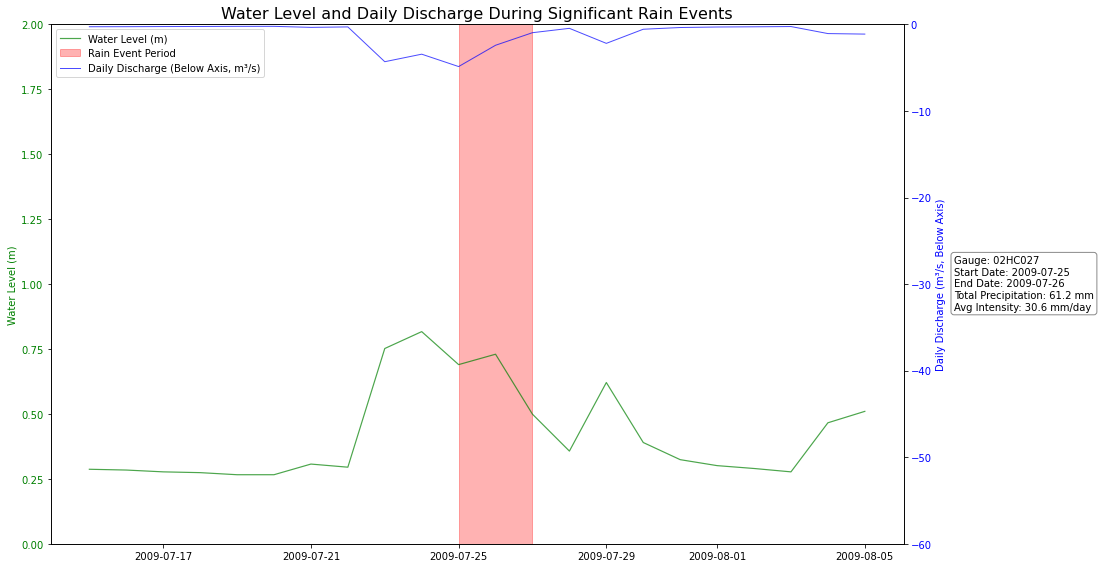

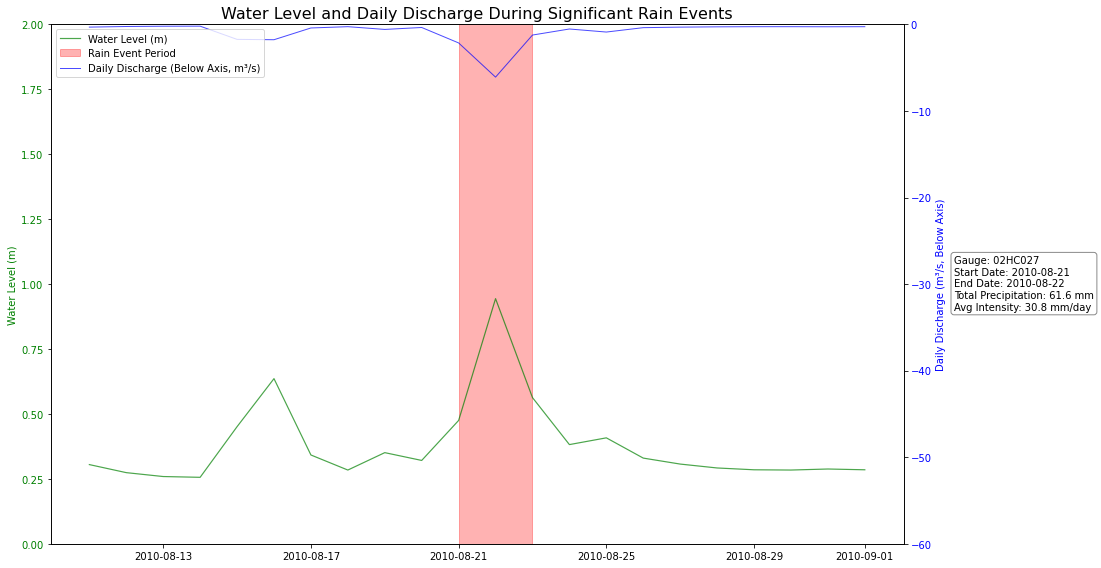

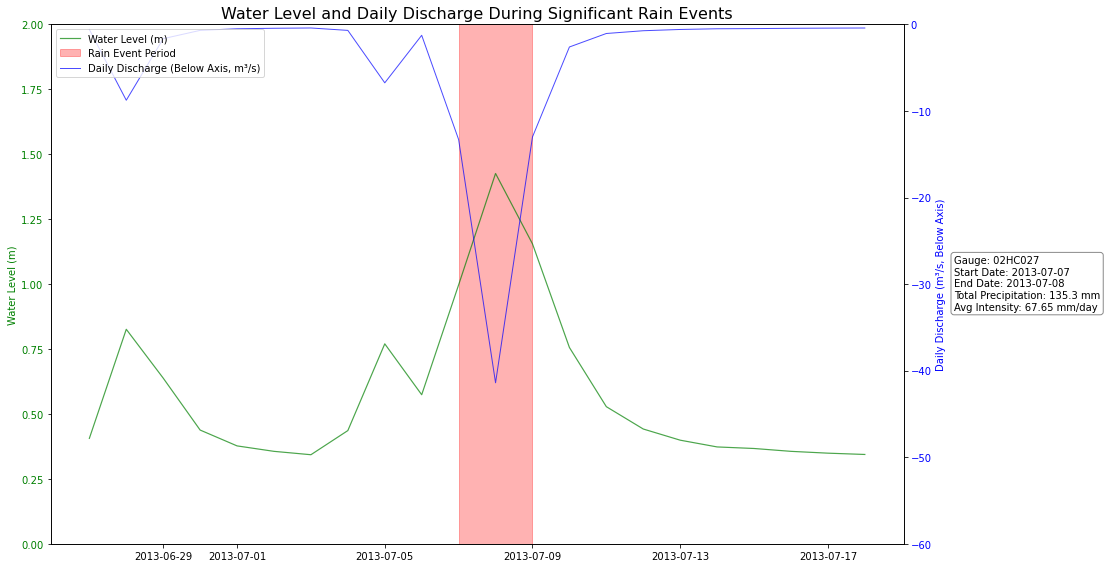

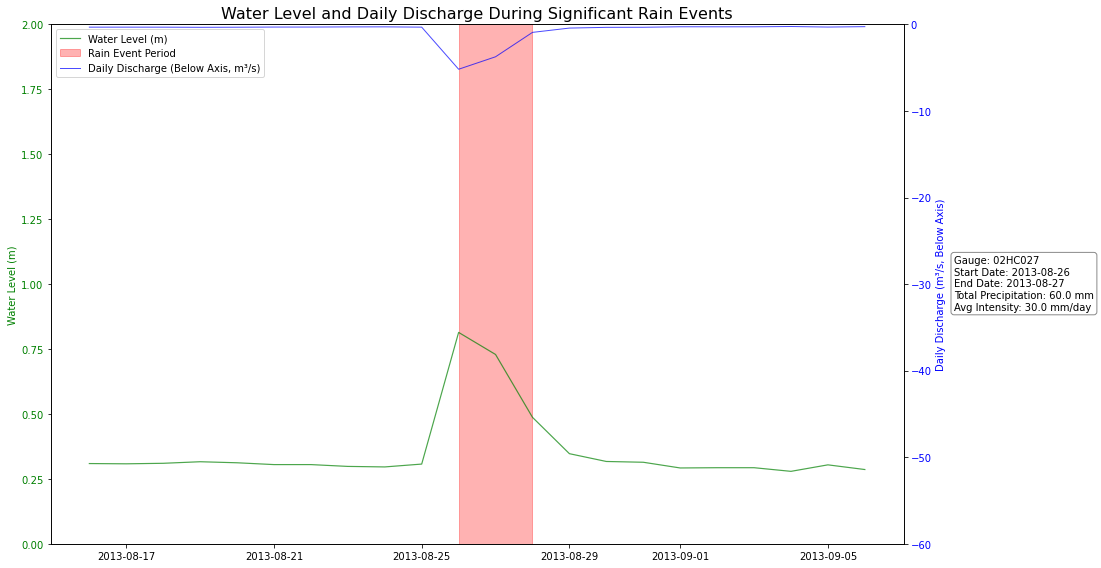

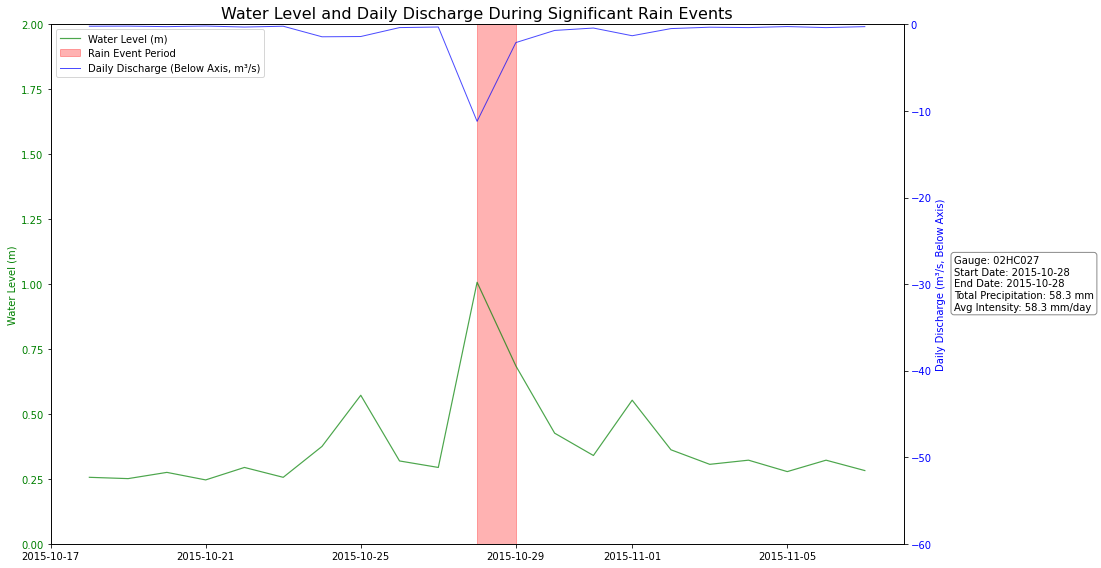

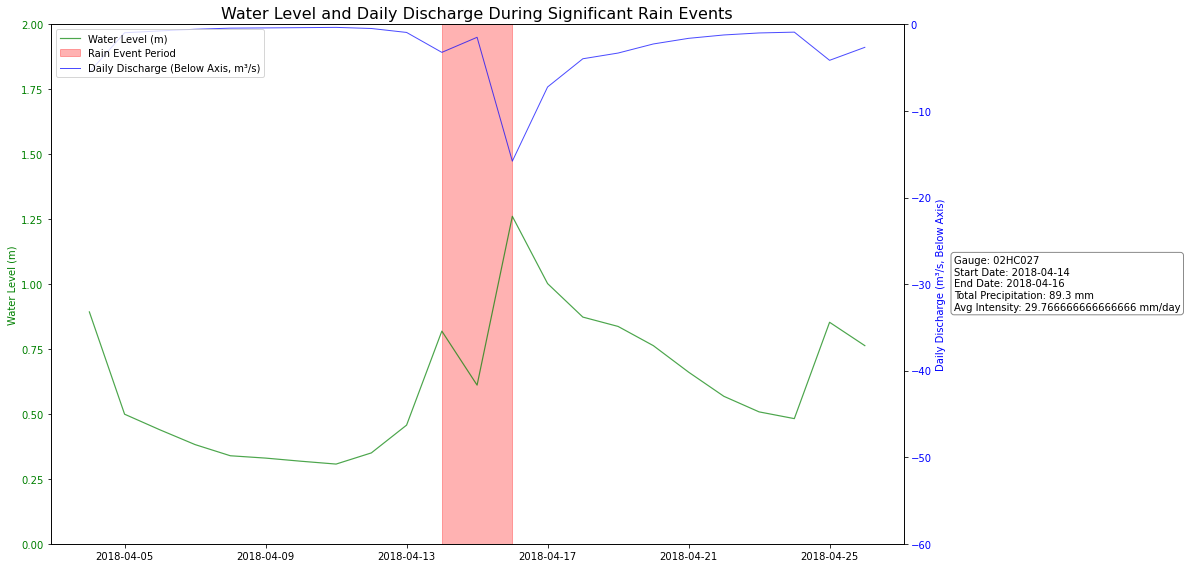

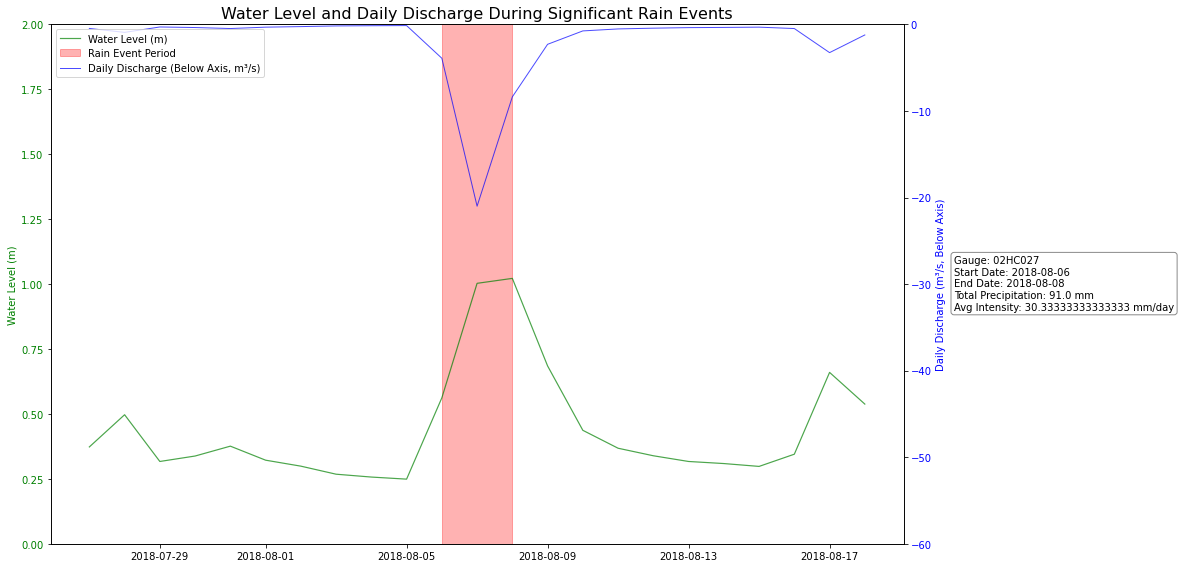

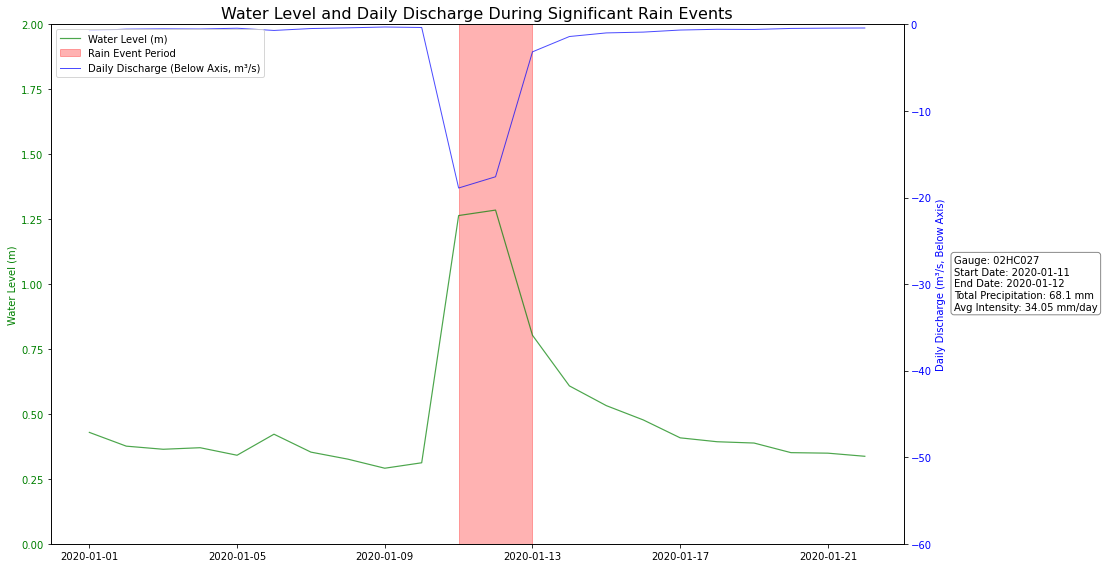

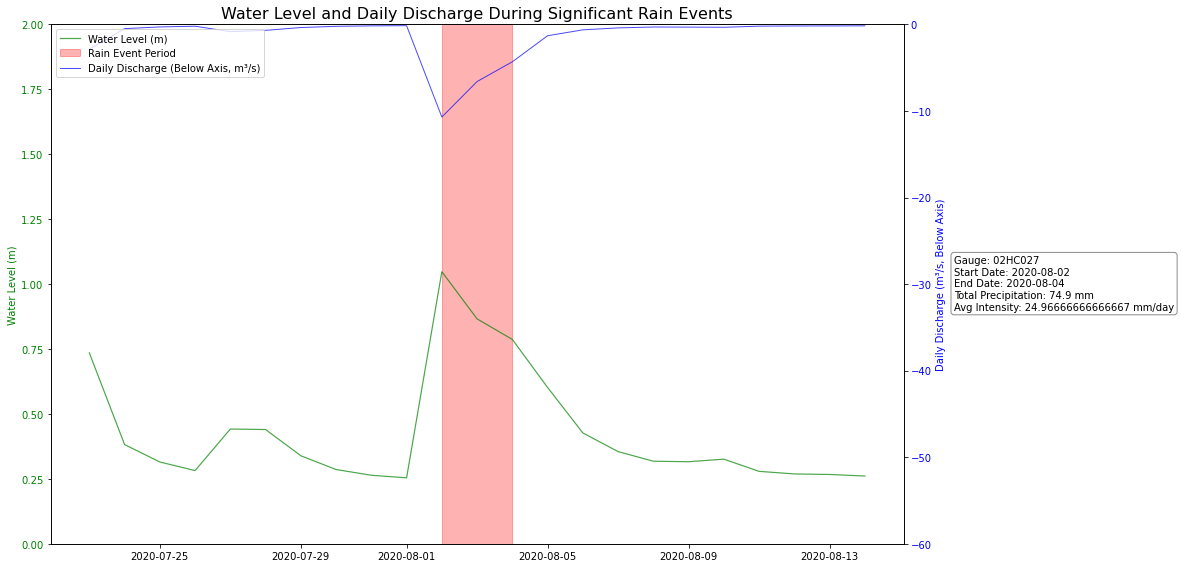

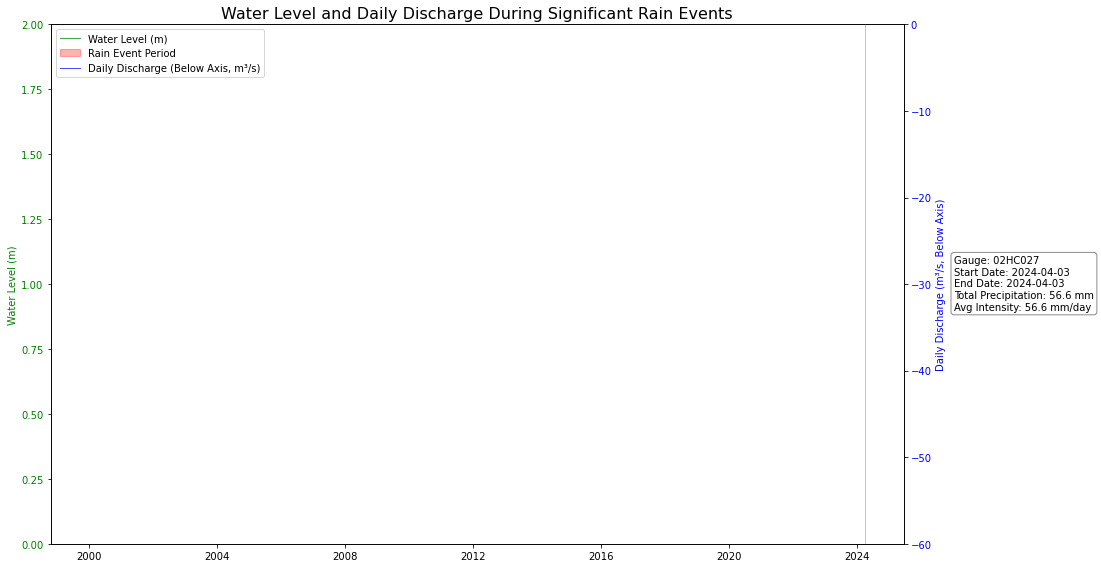

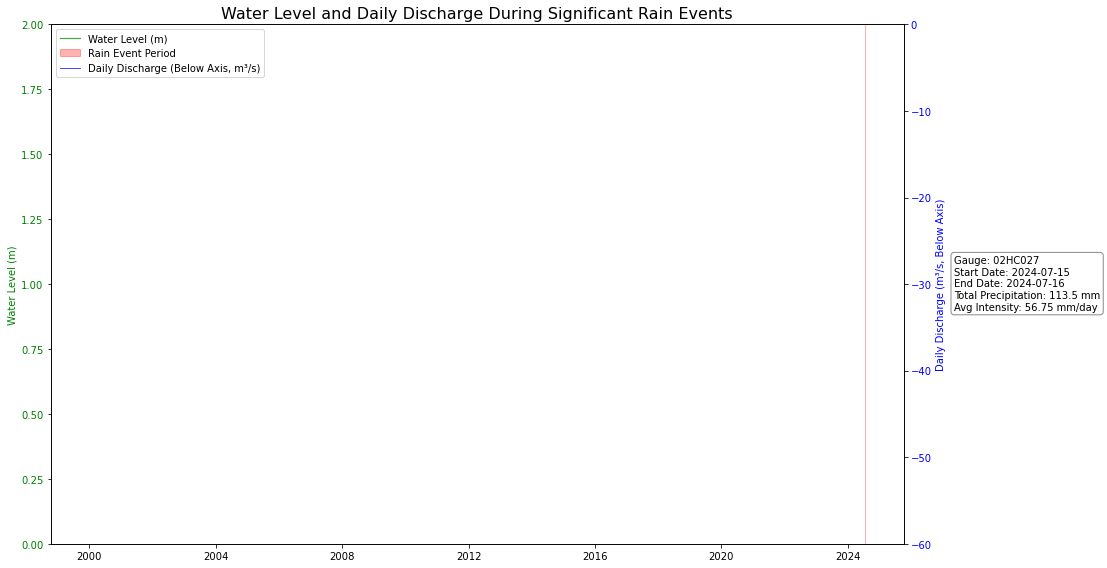

In [29]:
# Plot for Gauge 02HC027
plot_significant_rain_events(
    data=gauge_2_data,
    rain_events=significant_rain_events,
    gauge_id="02HC027",
    water_level_ylim=(0, 2),
    discharge_ylim=(-60, 0)
)


### Now we would want to analyze/compare water level and precipitation for 5 year periods starting from 2002

### We will also analyze precipitation data below

In [30]:
climate_data = pd.read_csv("processed_climate_data.csv")
climate_data["LOCAL_DATE"] = pd.to_datetime(climate_data["LOCAL_DATE"])
climate_data.head()

,LOCAL_DATE,MEAN_TEMPERATURE,TOTAL_PRECIPITATION
0,2002-06-04,11.6,4.8
1,2002-06-05,17.4,3.4
2,2002-06-06,15.3,0.0
3,2002-06-07,16.2,0.0
4,2002-06-08,18.3,0.0


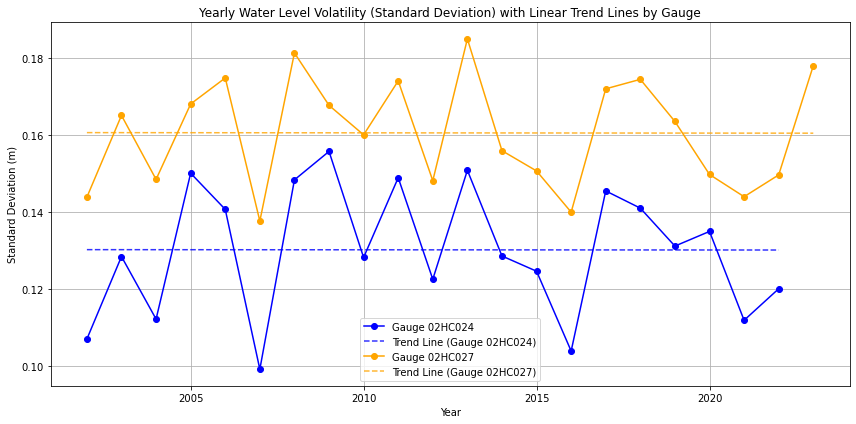

In [31]:
# Add Year column
flow_data_merged["Year"] = pd.to_datetime(flow_data_merged["Date"]).dt.year

# Calculate standard deviation of water level for each year, grouped by gauge
std_by_year = flow_data_merged.groupby(["ID", "Year"])["water_level"].std().reset_index()

std_by_year.columns = ["Gauge ID", "Year", "Std Dev Water Level"]

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red']  

for idx, gauge in enumerate(std_by_year["Gauge ID"].unique()):
    # Filter data for the current gauge
    gauge_data = std_by_year[std_by_year["Gauge ID"] == gauge]
    
    # Plot the standard deviation for each year
    plt.plot(
        gauge_data["Year"],
        gauge_data["Std Dev Water Level"],
        marker="o",
        label=f"Gauge {gauge}",
        color=colors[idx % len(colors)],
    )
    
    # Fit a linear trend line
    z = np.polyfit(gauge_data["Year"], gauge_data["Std Dev Water Level"], 1)  
    p = np.poly1d(z)
    trend_line = p(gauge_data["Year"])
    
    # Plot the linear trend line
    plt.plot(
        gauge_data["Year"],
        trend_line,
        linestyle="--",
        color=colors[idx % len(colors)],
        label=f"Trend Line (Gauge {gauge})",
        alpha=0.8,
    )

# Add plot title and labels
plt.title("Yearly Water Level Volatility (Standard Deviation) with Linear Trend Lines by Gauge")
plt.xlabel("Year")
plt.ylabel("Standard Deviation (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Create separate DataFrames for PARAM = 1 and PARAM = 2 
param_1_data = flow_data[flow_data["PARAM"] == 1][["ID", "Date", "Value"]].rename(columns={"Value": "daily_discharge"})
param_2_data = flow_data[flow_data["PARAM"] == 2][["ID", "Date", "Value"]].rename(columns={"Value": "water_level"})

# Merge the two DataFrames on ID and Date
flow_data_merged_new = pd.merge(param_1_data, param_2_data, on=["ID", "Date"], how="outer")

# Verify the merged DataFrame
print(flow_data_merged_new) # Create a new flow_data_merged dataframe to include data from 1966 for further analysis

            ID        Date  daily_discharge  water_level
0      02HC027  1966/07/04            0.357          NaN
1      02HC027  1966/07/05            0.249          NaN
2      02HC027  1966/07/06            0.275          NaN
3      02HC027  1966/07/07            0.337          NaN
4      02HC027  1966/07/08            0.252          NaN
...        ...         ...              ...          ...
43002  02HC024  2022/12/27            2.280       12.141
43003  02HC024  2022/12/28            2.150       12.134
43004  02HC024  2022/12/29            2.490       12.151
43005  02HC024  2022/12/30            4.920       12.249
43006  02HC024  2022/12/31           26.400       12.767

[43007 rows x 4 columns]


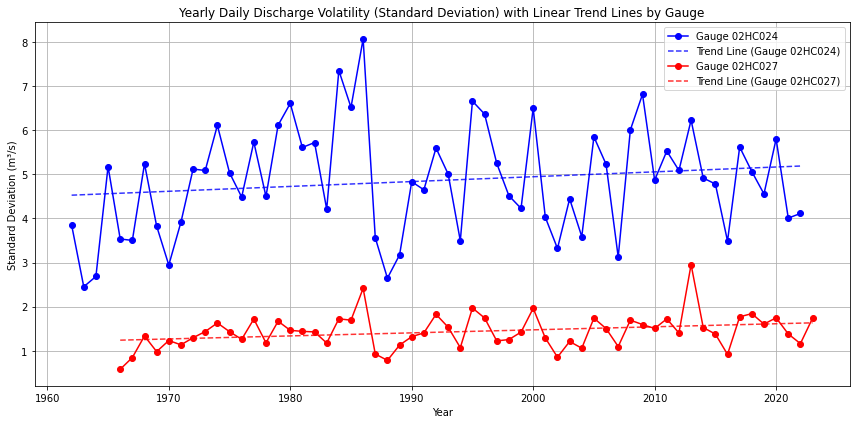

In [33]:

# Add Year Column
flow_data_merged_new["Year"] = pd.to_datetime(flow_data_merged_new["Date"]).dt.year

# Calculate standard deviation of daily discharge for each year, grouped by gauge
std_by_year_discharge = flow_data_merged_new.groupby(["ID", "Year"])["daily_discharge"].std().reset_index()

std_by_year_discharge.columns = ["Gauge ID", "Year", "Std Dev Daily Discharge"]

plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'orange', 'green']  

for idx, gauge in enumerate(std_by_year_discharge["Gauge ID"].unique()):
    # Filter data for the current gauge
    gauge_data = std_by_year_discharge[std_by_year_discharge["Gauge ID"] == gauge]
    
    # Plot the standard deviation for each year
    plt.plot(
        gauge_data["Year"],
        gauge_data["Std Dev Daily Discharge"],
        marker="o",
        label=f"Gauge {gauge}",
        color=colors[idx % len(colors)],
    )
    
    # Fit a linear trend line
    z = np.polyfit(gauge_data["Year"], gauge_data["Std Dev Daily Discharge"], 1)  
    p = np.poly1d(z)
    trend_line = p(gauge_data["Year"])
    
    # Plot the linear trend line
    plt.plot(
        gauge_data["Year"],
        trend_line,
        linestyle="--",
        color=colors[idx % len(colors)],
        label=f"Trend Line (Gauge {gauge})",
        alpha=0.8,
    )

plt.title("Yearly Daily Discharge Volatility (Standard Deviation) with Linear Trend Lines by Gauge")
plt.xlabel("Year")
plt.ylabel("Standard Deviation (m³/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### As we noticed earlier, the water level increases during snowmelts events. Hence, let's look how different is the avrage water level during snowmelt events and non-snowmelt events

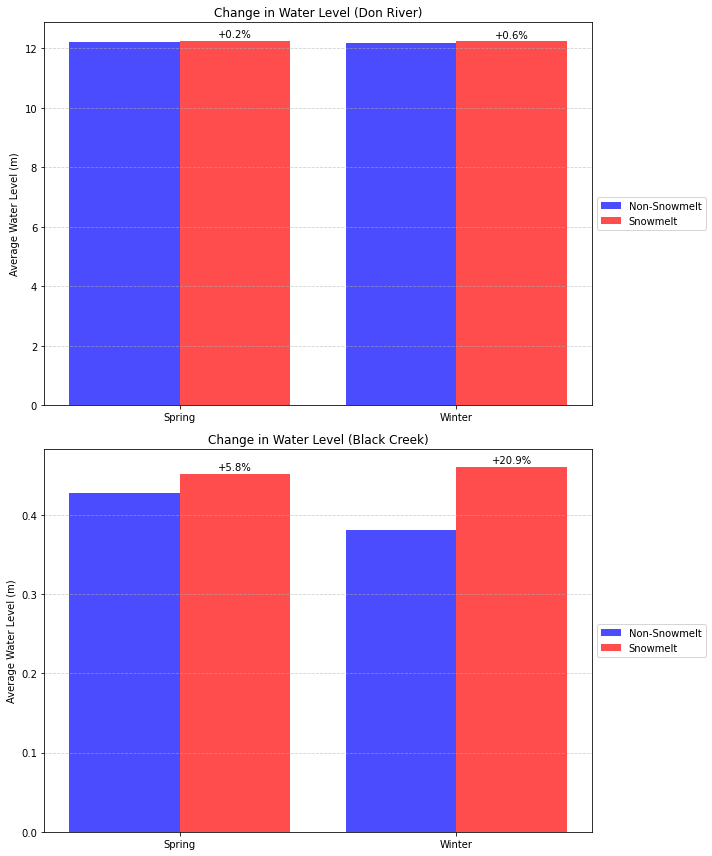

In [34]:
# Step 1: Add a column indicating snowmelt periods
flow_data_merged["is_snowmelt"] = False  # Default to non-snowmelt

# Mark snowmelt periods in the flow_data_merged DataFrame
for _, row in snowmelt_data.iterrows():
    flow_data_merged.loc[
        (flow_data_merged["Date"] >= row["start_date"]) & (flow_data_merged["Date"] <= row["end_date"]),
        "is_snowmelt"
    ] = True

# Step 2: Add a season column
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    else:
        return "Other"

flow_data_merged["Season"] = flow_data_merged["Date"].dt.month.apply(get_season)

# Step 3: Filter for winter and spring
filtered_data = flow_data_merged[flow_data_merged["Season"].isin(["Winter", "Spring"])]

# Step 4: Calculate average water level for snowmelt and non-snowmelt periods for each gauge and season
avg_wl_by_gauge = filtered_data.groupby(["ID", "Season", "is_snowmelt"])["water_level"].mean().reset_index()
avg_wl_by_gauge = avg_wl_by_gauge.pivot(index=["ID", "Season"], columns="is_snowmelt", values="water_level")
avg_wl_by_gauge.columns = ["Non-Snowmelt", "Snowmelt"]

# Step 5: Calculate % increase in WL during snowmelt for each gauge
avg_wl_by_gauge["% Increase"] = ((avg_wl_by_gauge["Snowmelt"] - avg_wl_by_gauge["Non-Snowmelt"]) / avg_wl_by_gauge["Non-Snowmelt"]) * 100

# Plot for Gauge 02HC024
plt.figure(figsize=(10, 12))

# Subplot 1: Gauge 02HC024
plt.subplot(2, 1, 1)
gauge_data_1 = avg_wl_by_gauge.loc["02HC024"].reset_index()

x_positions = np.arange(len(gauge_data_1["Season"]))
bar_width = 0.4

# Plot bars for non-snowmelt and snowmelt
plt.bar(
    x_positions - bar_width / 2,
    gauge_data_1["Non-Snowmelt"],
    color="blue",
    width=bar_width,
    label="Non-Snowmelt",
    alpha=0.7,
)
plt.bar(
    x_positions + bar_width / 2,
    gauge_data_1["Snowmelt"],
    color="red",
    width=bar_width,
    label="Snowmelt",
    alpha=0.7,
)

# Add % increase text annotations
for i, row in gauge_data_1.iterrows():
    y_position = max(row["Non-Snowmelt"], row["Snowmelt"]) + 0.1 
    plt.text(
        x_positions[i] + bar_width / 2,
        y_position,
        f"+{row['% Increase']:.1f}%",
        ha="center",
        fontsize=10,
        color="black",
    )

plt.title("Change in Water Level (Don River)")
plt.ylabel("Average Water Level (m)")
plt.xticks(x_positions, gauge_data_1["Season"])
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Position legend on the right side
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Subplot 2: Gauge 02HC027
plt.subplot(2, 1, 2)
gauge_data_2 = avg_wl_by_gauge.loc["02HC027"].reset_index()

x_positions = np.arange(len(gauge_data_2["Season"]))

# Plot bars for non-snowmelt and snowmelt
plt.bar(
    x_positions - bar_width / 2,
    gauge_data_2["Non-Snowmelt"],
    color="blue",
    width=bar_width,
    label="Non-Snowmelt",
    alpha=0.7,
)
plt.bar(
    x_positions + bar_width / 2,
    gauge_data_2["Snowmelt"],
    color="red",
    width=bar_width,
    label="Snowmelt",
    alpha=0.7,
)

# Add % increase text annotations
for i, row in gauge_data_2.iterrows():
    y_position = max(row["Non-Snowmelt"], row["Snowmelt"]) + 0.005 
    plt.text(
        x_positions[i] + bar_width / 2,
        y_position,
        f"+{row['% Increase']:.1f}%",
        ha="center",
        fontsize=10,
        color="black",
    )

plt.title("Change in Water Level (Black Creek)")
plt.ylabel("Average Water Level (m)")
plt.xticks(x_positions, gauge_data_2["Season"])
plt.grid(axis="y", linestyle="--", alpha=0.6)


plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


<ipython-input-35-c706e8ed2035>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_water_levels["Category"] = categories


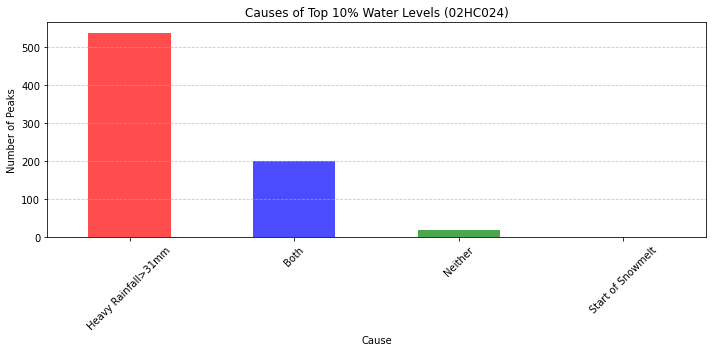

<ipython-input-35-c706e8ed2035>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_water_levels["Category"] = categories


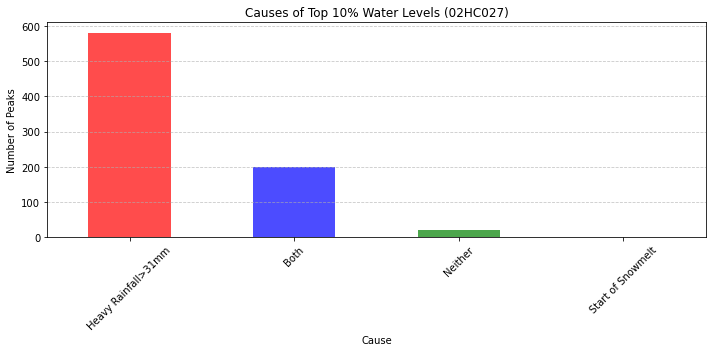

In [35]:
# Load the snowmelt data
snowmelt_data = pd.read_csv('significant_snow_melt_events_after_freeze.csv')

# Ensure date columns are in datetime format
snowmelt_data["start_date"] = pd.to_datetime(snowmelt_data["start_date"])
snowmelt_data["end_date"] = pd.to_datetime(snowmelt_data["end_date"])

# Load and filter rain events (total precipitation > 5mm)
climate_data = pd.read_csv("processed_climate_data.csv")
climate_data["LOCAL_DATE"] = pd.to_datetime(climate_data["LOCAL_DATE"])  # Ensure date is in datetime format
rain_events = climate_data[climate_data["TOTAL_PRECIPITATION"] > 31].copy()

# Create rain events based on consecutive precipitation days
rain_events["event_id"] = (rain_events["TOTAL_PRECIPITATION"].shift() <= 31) | (rain_events["TOTAL_PRECIPITATION"] <= 31)
rain_events["event_id"] = rain_events["event_id"].cumsum()

# Group by event_id to get start and end dates of each event
rain_event_dates = rain_events.groupby("event_id").agg(
    start_date=('LOCAL_DATE', 'min'),
    end_date=('LOCAL_DATE', 'max')
).reset_index()

# Separate by gauges
gauges = flow_data_merged["ID"].unique()

for gauge in gauges:
    # Filter data for the current gauge
    gauge_data = flow_data_merged[flow_data_merged["ID"] == gauge]
    
    # Calculate the threshold for top 10% water levels
    top_10_percent_threshold = gauge_data["water_level"].quantile(0.9)
    
    # Identify peak water levels (top 10%)
    peak_water_levels = gauge_data[gauge_data["water_level"] > top_10_percent_threshold]
    
    # Classify peaks based on rain events and the first 10 days of a snowmelt event
    categories = []
    for _, row in peak_water_levels.iterrows():
        date = row["Date"]
        
        # Check if the date falls within any rain event (extended by 1 day at the end)
        rain_event_match = rain_event_dates[rain_event_dates["start_date"] <= date]
        in_rainfall = False
        for _, rain_row in rain_event_match.iterrows():
            extended_end_date = rain_row["end_date"] + pd.Timedelta(days=1)
            # Check if the peak falls within the extended rain event
            if rain_row["start_date"] <= date <= extended_end_date:
                in_rainfall = True
        
        # Check if the date is within the first 10 days of a snowmelt event
        first_10_days_snowmelt = any(
            (snowmelt_data["start_date"] <= date) & (snowmelt_data["start_date"] + pd.Timedelta(days=10) >= date)
        )
        
        # Determine the category
        if first_10_days_snowmelt and in_rainfall:
            categories.append("Both")
        elif first_10_days_snowmelt:
            categories.append("Start of Snowmelt -first 10 days")
        elif in_rainfall:
            categories.append("Heavy Rainfall>31mm")
        else:
            categories.append("Neither")
    
    # Add categories to the peak water levels DataFrame
    peak_water_levels["Category"] = categories
    
    # Count the occurrences of each category
    category_counts = peak_water_levels["Category"].value_counts()
    
    # Ensure the "Start of Snowmelt" category is visible
    if "Start of Snowmelt" not in category_counts:
        category_counts["Start of Snowmelt"] = 0  # Add the category if missing
    
    # Visualization
    plt.figure(figsize=(10, 5))
    category_counts.plot(kind="bar", color=["red", "blue", "green", "purple"], alpha=0.7)
    plt.title(f"Causes of Top 10% Water Levels ({gauge})")
    plt.xlabel("Cause")
    plt.ylabel("Number of Peaks")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [36]:
# Ensure dates are in datetime format
climate_data["LOCAL_DATE"] = pd.to_datetime(climate_data["LOCAL_DATE"])
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])

# Identify rainfall events (precipitation > 5mm)
rain_events = climate_data[climate_data["TOTAL_PRECIPITATION"] > 20].copy()

# Create rain events based on consecutive high-precipitation days
rain_events["event_id"] = (rain_events["TOTAL_PRECIPITATION"].shift() <= 20) | (rain_events["TOTAL_PRECIPITATION"] <= 20)
rain_events["event_id"] = rain_events["event_id"].cumsum()

# Extend each event by 1 day (check the last day of the event and extend it)
rain_events["extended_end_date"] = rain_events["LOCAL_DATE"] + pd.Timedelta(days=1)

# Merge filtered precipitation data with flow data on dates
merged_data = pd.merge(
    rain_events,
    flow_data_merged,
    left_on="LOCAL_DATE",
    right_on="Date",
    how="inner"
)

# Filter out rows where the date does not fall within the rain event period
merged_data["in_rain_event"] = merged_data.apply(
    lambda x: x["LOCAL_DATE"] <= x["extended_end_date"], axis=1
)

# Compute correlation between total precipitation and water level
correlation = merged_data[merged_data["in_rain_event"]]["TOTAL_PRECIPITATION"].corr(
    merged_data[merged_data["in_rain_event"]]["water_level"]
)

# Print correlation
print(f"Correlation between Total Precipitation (with 1-day extension) and Water Level: {correlation:.4f}")

# Optional: View merged data
print(merged_data.head())

Correlation between Total Precipitation (with 1-day extension) and Water Level: 0.0176
  LOCAL_DATE  MEAN_TEMPERATURE  TOTAL_PRECIPITATION  event_id  \
0 2002-07-18              24.0                 26.8         0   
1 2002-07-18              24.0                 26.8         0   
2 2002-09-27              15.8                 33.6         0   
3 2002-09-27              15.8                 33.6         0   
4 2002-11-10              13.9                 34.8         0   

  extended_end_date       ID       Date  daily_discharge  water_level  \
0        2002-07-19  02HC024 2002-07-18             6.56       12.251   
1        2002-07-19  02HC027 2002-07-18             3.50        0.512   
2        2002-09-28  02HC027 2002-09-27             5.99        0.789   
3        2002-09-28  02HC024 2002-09-27            20.50       12.566   
4        2002-11-11  02HC027 2002-11-10             4.90        0.561   

  YearMonth  snowmelt_event  Year  is_snowmelt Season  in_rain_event  
0   2002-07 

Columns after merging with climate_data: Index(['ID', 'Date', 'daily_discharge', 'water_level', 'YearMonth',
       'snowmelt_event', 'Year', 'is_snowmelt', 'Season', 'LOCAL_DATE',
       'TOTAL_PRECIPITATION', 'MEAN_TEMPERATURE', 'rainfall_event'],
      dtype='object')
Columns after merging with snowmelt_data: Index(['ID', 'Date', 'daily_discharge', 'water_level', 'YearMonth',
       'snowmelt_event', 'Year', 'is_snowmelt', 'Season', 'LOCAL_DATE',
       'TOTAL_PRECIPITATION', 'MEAN_TEMPERATURE', 'rainfall_event',
       'start_date', 'start_of_snowmelt_event'],
      dtype='object')
        ID       Date  daily_discharge  water_level YearMonth  snowmelt_event  \
0  02HC024 2002-06-04            3.430       12.212   2002-06            True   
1  02HC027 2002-06-04            1.040        0.471   2002-06            True   
2  02HC027 2002-06-05            1.050        0.516   2002-06            True   
3  02HC024 2002-06-05            3.880       12.243   2002-06            True   
4 

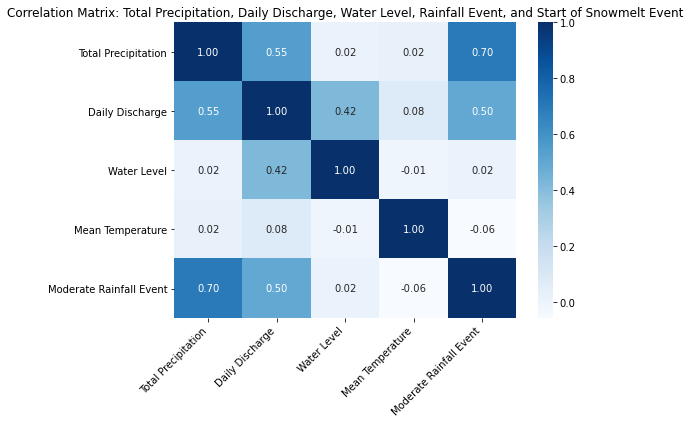

In [37]:
# Ensure 'Date' columns are in datetime format
climate_data["LOCAL_DATE"] = pd.to_datetime(climate_data["LOCAL_DATE"])
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])

# Create a 'rainfall_event' column in climate_data where total precipitation > 20mm
climate_data['rainfall_event'] = climate_data['TOTAL_PRECIPITATION'] > 20

# Add 'start_of_snowmelt_event' to snowmelt_data, which is the first 10 days of the snowmelt event
snowmelt_data["start_of_snowmelt_event"] = snowmelt_data["start_date"] + pd.Timedelta(days=10)

# Merge flow_data_merged with climate_data on dates, including only the necessary columns
merged_data = pd.merge(
    flow_data_merged,
    climate_data[['LOCAL_DATE', 'TOTAL_PRECIPITATION', 'MEAN_TEMPERATURE', 'rainfall_event']],  # Include all necessary columns from climate_data
    left_on="Date",
    right_on="LOCAL_DATE",
    how="inner"
)

# Print columns to check if 'TOTAL_PRECIPITATION' and 'MEAN_TEMPERATURE' are included
print("Columns after merging with climate_data:", merged_data.columns)

# Merge with snowmelt data to get the start of snowmelt event
merged_data = pd.merge(
    merged_data,
    snowmelt_data[['start_date', 'start_of_snowmelt_event']],  # Ensure these are present in snowmelt_data
    left_on="Date",
    right_on="start_date",
    how="left"
)

# Print columns after merging with snowmelt data to verify if 'start_of_snowmelt_event' is added
print("Columns after merging with snowmelt_data:", merged_data.columns)

# Print the first few rows to inspect data
print(merged_data.head())

# Select relevant columns for correlation and drop rows with missing values
correlation_data = merged_data[["TOTAL_PRECIPITATION", "daily_discharge", "water_level", "MEAN_TEMPERATURE", "rainfall_event", "start_of_snowmelt_event"]].dropna()

# Rename columns for clarity
correlation_data.rename(columns={
    "TOTAL_PRECIPITATION": "Total Precipitation",
    "daily_discharge": "Daily Discharge",
    "water_level": "Water Level",
    "MEAN_TEMPERATURE": "Mean Temperature",
    "rainfall_event": "Moderate Rainfall Event",
    "start_of_snowmelt_event": "Start of Snowmelt Event"
}, inplace=True)

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    cbar=True,
    annot_kws={"size": 10}
)

# Customize the plot
plt.title("Correlation Matrix: Total Precipitation, Daily Discharge, Water Level, Rainfall Event, and Start of Snowmelt Event", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### From the graph we can notice that Water level has a correlation of 0.42 with Daily discharge, and Daily discharge has a correlation of 0.55 with total precipitation. 

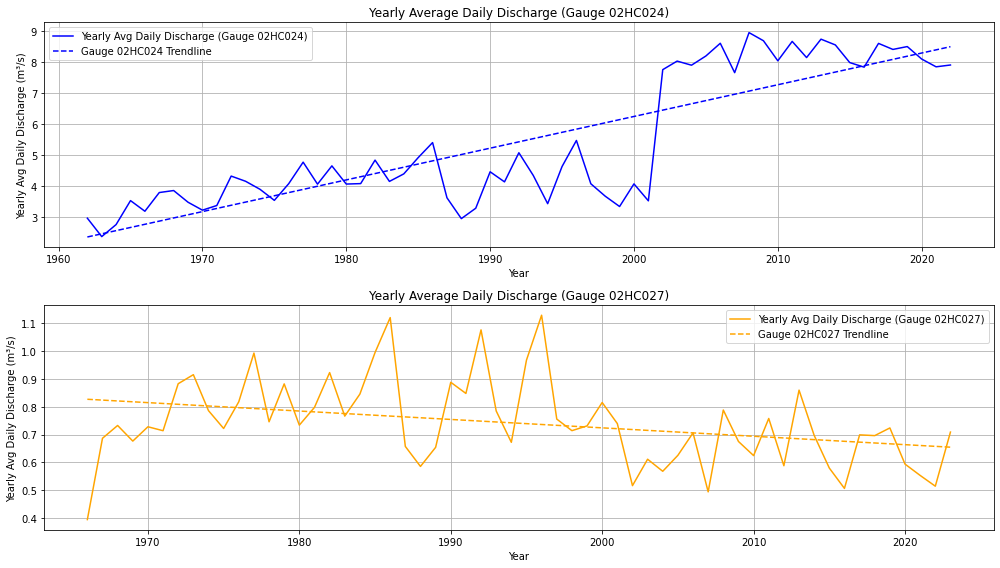

In [38]:
# Function to add trendline to the plot
def add_trendline(x, y, label, color):
    # Convert the dates to the number of days since the first date
    x_numeric = (x - x.min()).dt.total_seconds() / (60 * 60 * 24)  # Convert to days
    
    # Fit a linear trendline to the data
    trendline = np.polyfit(x_numeric, y, 1)
    trendline_fn = np.poly1d(trendline)
    
    # Plot the trendline
    plt.plot(x, trendline_fn(x_numeric), linestyle="--", label=f"{label} Trendline", color=color)

# Load the flow data
flow_data_merged = pd.read_csv('flow data.csv', skiprows=1)

# Convert the 'Date' column to datetime format
flow_data_merged["Date"] = pd.to_datetime(flow_data_merged["Date"])
flow_data_merged = flow_data_merged.sort_values(by="Date").reset_index(drop=True)

# Filter data for daily discharge (PARAM = 1)
gauge_1_data = flow_data_merged[flow_data_merged["ID"] == "02HC024"]
gauge_2_data = flow_data_merged[flow_data_merged["ID"] == "02HC027"]

# Extract the year from the 'Date' column and group by year
gauge_1_yearly_avg = gauge_1_data.groupby(gauge_1_data["Date"].dt.year)["Value"].mean().reset_index()
gauge_2_yearly_avg = gauge_2_data.groupby(gauge_2_data["Date"].dt.year)["Value"].mean().reset_index()

# Convert 'Year' column to datetime, setting the first date of each year
gauge_1_yearly_avg["Date"] = pd.to_datetime(gauge_1_yearly_avg["Date"].astype(str) + '-01-01')
gauge_2_yearly_avg["Date"] = pd.to_datetime(gauge_2_yearly_avg["Date"].astype(str) + '-01-01')

# Plot the yearly average daily discharge with trendline for each gauge
plt.figure(figsize=(14, 8))

# Subplot for Gauge 02HC024
plt.subplot(2, 1, 1)
plt.plot(gauge_1_yearly_avg["Date"], gauge_1_yearly_avg["Value"], label="Yearly Avg Daily Discharge (Gauge 02HC024)", color="blue")
add_trendline(gauge_1_yearly_avg["Date"], gauge_1_yearly_avg["Value"].values, "Gauge 02HC024", "blue")
plt.xlabel("Year")
plt.ylabel("Yearly Avg Daily Discharge (m³/s)")
plt.title("Yearly Average Daily Discharge (Gauge 02HC024)")
plt.legend()
plt.grid(True)

# Subplot for Gauge 02HC027
plt.subplot(2, 1, 2)
plt.plot(gauge_2_yearly_avg["Date"], gauge_2_yearly_avg["Value"], label="Yearly Avg Daily Discharge (Gauge 02HC027)", color="orange")
add_trendline(gauge_2_yearly_avg["Date"], gauge_2_yearly_avg["Value"].values, "Gauge 02HC027", "orange")
plt.xlabel("Year")
plt.ylabel("Yearly Avg Daily Discharge (m³/s)")
plt.title("Yearly Average Daily Discharge (Gauge 02HC027)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()